In [1]:
!pip install -q amplpy
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi", "cplex"], # pick from over 20 modules including most commercial and open-source solvers
    license_uuid="ef216baf-1a82-48a2-ad66-5e4609a7f099") # your license UUID (e.g., free ampl.com/ce or ampl.com/courses licenses)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 77.0 MB/s eta 0:00:00
Licensed to AMPL Academic Community Edition License for <x23353414@student.ncirl.ie>.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from amplpy import AMPL, ampl_notebook
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

In [3]:
# Define PyTorch neural network model
class IndexTrackingNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout_rate=0.3):
        """
        Neural network model for S&P 100 index tracking

        Parameters:
        -----------
        input_size : int
            Number of features (stocks)
        hidden_size : int
            Size of hidden layers
        dropout_rate : float
            Dropout rate for regularization
        """
        super(IndexTrackingNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [4]:

class SPIndexFund:
    def __init__(self, q=20, lookback_period='2y', test_period='6mo', ampl=None, max_weight=0.20):
        """
        Initialize the SP 100 Index Fund Tracker

        Parameters:
        -----------
        q : int
            Number of stocks to select for the index fund
        lookback_period : str
            Period for historical data (e.g., '1y', '2y')
        test_period : str
            Period for out-of-sample testing (e.g., '3mo', '6mo')
        ampl : AMPL object
            Initialized AMPL object for optimization
        max_weight : float
            Maximum weight for any single stock (for diversification)
        """
        self.q = q
        self.lookback_period = lookback_period
        self.test_period = test_period
        self.ampl = ampl
        self.max_weight = max_weight

        # Data containers
        self.sp100_tickers = None
        self.price_data = None
        self.returns_data = None
        self.index_returns = None
        self.train_data = None
        self.test_data = None

        # Results containers
        self.ampl_weights = None
        self.nn_weights = None
        self.ampl_performance = None
        self.nn_performance = None

        # Multi-period evaluation results
        self.time_horizon_results = {}

        # Multi-q evaluation results
        self.q_analysis_results = {}

        # Set device for PyTorch
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        print(f"Initialized SP 100 Index Fund Tracker with q={q}")
        print(f"Will use {lookback_period} of historical data and test on {test_period}")
        print(f"Maximum weight per stock: {max_weight:.2f} (for diversification)")
        print(f"PyTorch device: {self.device}")

    def get_sp100_constituents(self):
        """
        Obtain the current list of S&P 100 constituents

        Returns:
        --------
        list: List of ticker symbols in the S&P 100 index
        """
        print("Fetching S&P 100 constituents...")

        # Method 1: Try to use Wikipedia data
        try:
            # Scrape S&P 100 constituents from Wikipedia
            url = "https://en.wikipedia.org/wiki/S%26P_100"
            tables = pd.read_html(url)

            # Find the table with the constituents
            for table in tables:
                if 'Symbol' in table.columns:
                    sp100 = table
                    break

            # Extract ticker symbols
            self.sp100_tickers = sp100['Symbol'].tolist()

            # Fix ticker formats for Yahoo Finance (e.g., BRK-B to BRK.B)
            self.sp100_tickers = [ticker.replace('-', '.') for ticker in self.sp100_tickers]

            print(f"Successfully retrieved {len(self.sp100_tickers)} S&P 100 constituents from Wikipedia")
            print("First 10 tickers: " + ", ".join(self.sp100_tickers[:10]))
            print("Last 10 tickers: " + ", ".join(self.sp100_tickers[-10:]))

        # Method 2: If Wikipedia fails, use a hardcoded list from a recent date
        except Exception as e:
            print(f"Error fetching from Wikipedia: {e}")
            print("Using backup S&P 100 list...")

            # This is a recent S&P 100 list (as of late 2023)
            # Note: Using the correct Yahoo Finance format with dots instead of hyphens
            self.sp100_tickers = [
                'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'BRK.B',
                'UNH', 'JPM', 'XOM', 'V', 'JNJ', 'PG', 'MA', 'HD', 'CVX', 'MRK',
                'LLY', 'AVGO', 'PEP', 'COST', 'ABBV', 'BAC', 'KO', 'PFE', 'TMO',
                'CSCO', 'MCD', 'ACN', 'ABT', 'CRM', 'DHR', 'LIN', 'WMT', 'ADBE',
                'DIS', 'TXN', 'VZ', 'NEE', 'PM', 'CMCSA', 'WFC', 'NKE', 'BMY',
                'RTX', 'ORCL', 'UPS', 'HON', 'T', 'INTC', 'QCOM', 'COP', 'IBM',
                'AMGN', 'CAT', 'LOW', 'INTU', 'BA', 'SPGI', 'AMD', 'GS', 'MDLZ',
                'PLD', 'DE', 'SBUX', 'AXP', 'LMT', 'GILD', 'ADI', 'TJX', 'MMM',
                'C', 'SYK', 'BLK', 'ISRG', 'AMAT', 'CVS', 'GE', 'BKNG', 'SCHW',
                'EOG', 'MO', 'TMUS', 'MS', 'REGN', 'NOW', 'MDT', 'AMT', 'FDX',
                'PGR', 'LRCX', 'NOC', 'SO', 'BDX', 'CL', 'CB', 'DUK', 'TGT', 'SPG'
            ]
            print(f"Using backup list with {len(self.sp100_tickers)} S&P 100 constituents")
            print("First 10 tickers: " + ", ".join(self.sp100_tickers[:10]))
            print("Last 10 tickers: " + ", ".join(self.sp100_tickers[-10:]))

        return self.sp100_tickers

    def download_historical_data(self, start_date=None, end_date=None):
        """
        Download historical price data for S&P 100 stocks using yfinance

        Parameters:
        -----------
        start_date : str, optional
            Start date for data (YYYY-MM-DD), if None will use lookback_period
        end_date : str, optional
            End date for data (YYYY-MM-DD), if None will use current date

        Returns:
        --------
        DataFrame: Historical price data for S&P 100 stocks
        """
        if self.sp100_tickers is None:
            self.get_sp100_constituents()

        # Set dates if not provided
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        if start_date is None:
            # Use lookback_period
            print(f"Downloading {self.lookback_period} of historical data for {len(self.sp100_tickers)} stocks...")
            print(f"Date range will end on {end_date}")
        else:
            print(f"Downloading historical data from {start_date} to {end_date} for {len(self.sp100_tickers)} stocks...")

        # Download data with error handling and retry logic
        max_retries = 3
        for attempt in range(max_retries):
            try:
                print(f"Download attempt {attempt+1}/{max_retries}...")
                if start_date is None:
                    # Use period parameter
                    data = yf.download(
                        self.sp100_tickers,
                        period=self.lookback_period,
                        group_by='ticker',
                        auto_adjust=True,
                        progress=False
                    )
                else:
                    # Use start and end dates
                    data = yf.download(
                        self.sp100_tickers,
                        start=start_date,
                        end=end_date,
                        group_by='ticker',
                        auto_adjust=True,
                        progress=False
                    )

                # Check if we have data
                if len(data) == 0:
                    print("No data returned, retrying...")
                    continue

                # Success!
                print(f"Download successful on attempt {attempt+1}")
                break

            except Exception as e:
                print(f"Error on attempt {attempt+1}: {e}")
                if attempt == max_retries - 1:
                    raise Exception(f"Failed to download data after {max_retries} attempts")
                print("Retrying download...")

        # Restructure data if it's a MultiIndex DataFrame
        if isinstance(data.columns, pd.MultiIndex):
            print("Processing multi-level DataFrame...")
            # Extract close prices
            close_prices = pd.DataFrame()
            successful_tickers = []
            failed_tickers = []

            for ticker in self.sp100_tickers:
                if ticker in data.columns.levels[0]:
                    try:
                        close_prices[ticker] = data[ticker]['Close']
                        successful_tickers.append(ticker)
                    except Exception as e:
                        print(f"Could not extract data for {ticker}: {e}")
                        failed_tickers.append(ticker)
                else:
                    failed_tickers.append(ticker)

            print(f"Successfully extracted data for {len(successful_tickers)} stocks")
            if failed_tickers:
                print(f"Failed to extract data for {len(failed_tickers)} stocks: {', '.join(failed_tickers[:5])}{' and more...' if len(failed_tickers) > 5 else ''}")

            self.price_data = close_prices
        else:
            # If it's a single ticker or not MultiIndex
            print("Processing single-level DataFrame...")
            self.price_data = data['Close'].to_frame()

        # Check for missing values
        missing_pct = self.price_data.isna().mean().sort_values(ascending=False)
        print(f"Stocks with highest percentage of missing values:")
        for ticker, pct in missing_pct.head(5).items():
            print(f"  {ticker}: {pct*100:.2f}% missing")

        # Remove any tickers with insufficient data (more than 10% missing)
        valid_tickers = self.price_data.columns[self.price_data.isna().mean() < 0.1]
        removed_tickers = list(set(self.price_data.columns) - set(valid_tickers))

        self.price_data = self.price_data[valid_tickers].copy()

        if removed_tickers:
            print(f"Removed {len(removed_tickers)} tickers with >10% missing data: {', '.join(removed_tickers[:5])}{' and more...' if len(removed_tickers) > 5 else ''}")

        # Forward fill remaining missing values and then backfill
        missing_before = self.price_data.isna().sum().sum()
        self.price_data = self.price_data.fillna(method='ffill').fillna(method='bfill')
        missing_after = self.price_data.isna().sum().sum()

        print(f"Filled {missing_before} missing values using forward/backward fill")
        print(f"Remaining missing values: {missing_after}")
        print(f"Successfully downloaded data for {self.price_data.shape[1]} stocks over {self.price_data.shape[0]} trading days")
        print(f"First 5 stocks in dataset: {', '.join(self.price_data.columns[:5])}")

        return self.price_data

    def calculate_returns(self):
        """
        Calculate daily returns from price data

        Returns:
        --------
        DataFrame: Daily returns for all stocks
        """
        if self.price_data is None:
            raise Exception("No price data available. Run download_historical_data first.")

        print("Calculating daily returns...")

        # Calculate daily returns
        self.returns_data = self.price_data.pct_change().dropna()

        # Create equal-weighted index returns (proxy for S&P 100)
        self.index_returns = self.returns_data.mean(axis=1)

        print(f"Calculated returns for {self.returns_data.shape[1]} stocks over {self.returns_data.shape[0]} trading days")
        return self.returns_data

    def split_data(self, test_period=None):
        """
        Split data into training and testing periods based on specified time period

        Parameters:
        -----------
        test_period : str, optional
            Period for testing data (e.g., '3mo', '6mo', '9mo', '1y')
            If None, will use self.test_period

        Returns:
        --------
        tuple: (train_data, test_data) containing returns DataFrames
        """
        if self.returns_data is None:
            self.calculate_returns()

        # Use class test_period if none provided
        if test_period is None:
            test_period = self.test_period

        # Convert period to approximate number of trading days
        period_to_days = {
            '3mo': 63,   # ~63 trading days in 3 months
            '6mo': 126,  # ~126 trading days in 6 months
            '9mo': 189,  # ~189 trading days in 9 months
            '1y': 252    # ~252 trading days in a year
        }

        # Get test size in days, default to 20% if period not recognized
        if test_period in period_to_days:
            test_days = min(period_to_days[test_period], len(self.returns_data) // 2)
            print(f"Using {test_days} trading days for {test_period} test period")
        else:
            # Default to 20% as before
            test_days = int(len(self.returns_data) * 0.2)
            print(f"Using {test_days} trading days for test period (20% of data)")

        # Make sure we have enough data
        if test_days >= len(self.returns_data):
            test_days = len(self.returns_data) // 2
            print(f"Warning: Requested too many test days. Using {test_days} days instead.")

        # Split the data
        self.train_data = self.returns_data.iloc[:-test_days]
        self.test_data = self.returns_data.iloc[-test_days:]

        # Split the index returns as well
        self.train_index = self.index_returns.iloc[:-test_days]
        self.test_index = self.index_returns.iloc[-test_days:]

        print(f"Split data into {len(self.train_data)} training days and {len(self.test_data)} testing days")
        return self.train_data, self.test_data

    def optimize_with_ampl(self, improved=True):
        """
        Use AMPL to find optimal subset of stocks to track the index

        Parameters:
        -----------
        improved : bool
            Whether to use the improved diversification constraints

        Returns:
        --------
        dict: Optimal portfolio weights
        """
        if self.train_data is None:
            self.split_data()

        print("\n" + "="*80)
        print(f"AMPL OPTIMIZATION: Finding optimal {self.q} stocks to track S&P 100")
        print("="*80)

        # Prepare correlation data
        correlation = self.train_data.corrwith(self.train_index)
        cov_matrix = self.train_data.cov()
        var_index = self.train_index.var()
        mean_returns = self.train_data.mean()
        mean_index_return = self.train_index.mean()

        # Create AMPL model
        if self.ampl is None:
            try:
                self.ampl = AMPL()
            except Exception as e:
                print(f"Error initializing AMPL: {e}")
                print("Using correlation-based approach instead")
                return self.optimize_with_correlation()

        # Reset the AMPL environment
        self.ampl.reset()

        try:
            if improved:
                # Improved AMPL model with diversification constraints
                self.ampl.eval("""
                # Sets
                set STOCKS;

                # Parameters
                param Correlation{i in STOCKS};
                param ExactStocks;
                param MaxWeight;  # Maximum weight for any single stock

                # Variables
                var Weight{i in STOCKS} >= 0, <= MaxWeight;  # Portfolio weights with upper bound
                var Select{i in STOCKS} binary;      # 1 if stock is selected, 0 otherwise

                # Objective: Maximize correlation with diversification
                maximize Objective:
                    sum{i in STOCKS} Weight[i] * Correlation[i];

                # Constraints
                subject to SumWeights:
                    sum{i in STOCKS} Weight[i] = 1;

                # Exactly q stocks are selected
                subject to ExactSelectedStocks:
                    sum{i in STOCKS} Select[i] = ExactStocks;

                # Link selection to weights
                subject to LinkSelectWeight{i in STOCKS}:
                    Weight[i] <= Select[i] * MaxWeight;

                # Minimum weight for selected stocks (ensures meaningful allocation)
                subject to MinWeight{i in STOCKS}:
                    Weight[i] >= Select[i] * 0.01;  # At least 1% weight if selected
                """)

                # Set additional parameters for improved model
                self.ampl.param['MaxWeight'] = self.max_weight
            else:
                # Original AMPL model
                self.ampl.eval("""
                # Sets
                set STOCKS;

                # Parameters
                param Correlation{i in STOCKS};
                param ExactStocks;

                # Variables
                var Weight{i in STOCKS} >= 0, <= 1;  # Portfolio weights
                var Select{i in STOCKS} binary;      # 1 if stock is selected, 0 otherwise

                # Objective: Maximize correlation
                maximize Objective:
                    sum{i in STOCKS} Weight[i] * Correlation[i];

                # Constraints
                subject to SumWeights:
                    sum{i in STOCKS} Weight[i] = 1;

                # Changed to "=" instead of "<=" to ensure exactly q stocks are selected
                subject to ExactSelectedStocks:
                    sum{i in STOCKS} Select[i] = ExactStocks;

                subject to LinkSelectWeight{i in STOCKS}:
                    Weight[i] <= Select[i];
                """)

            # Set data
            stocks = list(self.train_data.columns)
            self.ampl.set['STOCKS'] = stocks

            # Set parameters
            self.ampl.param['Correlation'] = {stock: correlation[stock] for stock in stocks}
            self.ampl.param['ExactStocks'] = self.q

            # Set solver
            solver = 'highs' if 'highs' in self.ampl.get_option('solver').split() else 'cbc'
            self.ampl.option['solver'] = solver
            print(f"Using solver: {solver}")
            print(f"Optimization model: {'Improved (with diversification)' if improved else 'Basic'}")

            # Solve the model
            print("Solving AMPL optimization model...")
            self.ampl.solve()

            # Get solution status
            solve_result = self.ampl.get_value('solve_result')
            print(f"Solve result: {solve_result}")

            # Extract weights if solved successfully
            if solve_result in ['solved', 'solved?']:
                # Extract weights and selected stocks
                ampl_weights = {}
                for i in stocks:
                    weight = self.ampl.get_value(f'Weight["{i}"]')
                    selected = self.ampl.get_value(f'Select["{i}"]')
                    if selected > 0.5:  # Binary variable might have small numerical errors
                        ampl_weights[i] = weight

                # Normalize weights to sum to 1
                total = sum(ampl_weights.values())
                self.ampl_weights = {k: v/total for k, v in ampl_weights.items()}

                print(f"AMPL optimization selected {len(self.ampl_weights)} stocks")
                print("Top stocks with weights:")
                for stock, weight in sorted(self.ampl_weights.items(), key=lambda x: x[1], reverse=True)[:10]:
                    print(f"  {stock}: {weight:.4f}")

                # Calculate Herfindahl Index (concentration measure)
                herfindahl = sum(w**2 for w in self.ampl_weights.values())
                print(f"Portfolio concentration (Herfindahl Index): {herfindahl:.4f}")
                print(f"Weight of largest position: {max(self.ampl_weights.values()):.4f}")

                return self.ampl_weights
            else:
                print("AMPL optimization failed to find a solution")
                print("Using correlation-based approach instead")
                self.ampl_weights = self.optimize_with_correlation()
                return self.ampl_weights

        except Exception as e:
            print(f"Error solving AMPL model: {e}")
            print("Using correlation-based approach instead")
            self.ampl_weights = self.optimize_with_correlation()
            return self.ampl_weights

    def optimize_with_correlation(self):
        """
        Use correlation-based approach to track the index (fallback if AMPL fails)

        Returns:
        --------
        dict: Portfolio weights based on stock correlations with the index
        """
        if self.train_data is None:
            self.split_data()

        print("\nUsing correlation-based optimization as a fallback method")
        print(f"This approach selects exactly {self.q} stocks with the highest correlation to the index")

        # Calculate correlation of each stock with the index
        print("Calculating correlations between each stock and the index...")
        correlations = self.train_data.corrwith(self.train_index)

        # Show distribution of correlations
        print("\nCorrelation distribution:")
        corr_ranges = [(0.9, 1.0), (0.8, 0.9), (0.7, 0.8), (0.6, 0.7), (0.5, 0.6), (0, 0.5)]
        for lower, upper in corr_ranges:
            count = ((correlations >= lower) & (correlations < upper)).sum()
            print(f"  {lower:.1f}-{upper:.1f}: {count} stocks")

        # Select top q stocks with highest correlation
        top_stocks = correlations.sort_values(ascending=False).head(self.q)
        print(f"\nTop {self.q} most correlated stocks:")
        for i, (ticker, corr) in enumerate(top_stocks.items(), 1):
            print(f"  {i}. {ticker}: correlation = {corr:.4f}")

        # Calculate weights proportional to correlation with diversification constraints
        # Apply max weight constraint
        weights = top_stocks.copy()

        # Ensure no weight exceeds max_weight
        while any(w/top_stocks.sum() > self.max_weight for w in weights):
            # Identify stocks exceeding max weight
            excess_stocks = [stock for stock, w in weights.items() if w/weights.sum() > self.max_weight]

            # Cap these at max_weight * sum
            for stock in excess_stocks:
                weights[stock] = self.max_weight * weights.sum()

            # Re-normalize remaining stocks
            remaining_stocks = [stock for stock in weights.index if stock not in excess_stocks]
            remaining_weight = 1 - (len(excess_stocks) * self.max_weight)
            if remaining_weight <= 0 or not remaining_stocks:
                break  # Safety check

            # Redistribute remaining weight proportionally
            for stock in remaining_stocks:
                weights[stock] = weights[stock] / sum(weights[s] for s in remaining_stocks) * remaining_weight

        # Normalize to sum to 1
        weights = weights / weights.sum()

        # Convert to dictionary
        weights_dict = {ticker: weight for ticker, weight in weights.items()}

        print(f"\nSelected exactly {len(weights_dict)} stocks based on correlation")
        print("Final stock selection with weights:")
        for i, (stock, weight) in enumerate(sorted(weights_dict.items(), key=lambda x: x[1], reverse=True), 1):
            print(f"  {i}. {stock}: weight = {weight:.4f}, correlation = {correlations[stock]:.4f}")

        # Calculate concentration
        herfindahl = sum(w**2 for w in weights_dict.values())
        print(f"Portfolio concentration (Herfindahl Index): {herfindahl:.4f}")
        print(f"Weight of largest position: {max(weights_dict.values()):.4f}")

        # Always assign to self.ampl_weights to ensure it's not None
        self.ampl_weights = weights_dict

        return weights_dict

    def train_neural_network(self):
        """
        Train a neural network to identify important stocks for tracking the index

        Returns:
        --------
        dict: Neural network-based portfolio weights
        """
        if self.train_data is None:
            self.split_data()

        print("\n" + "="*80)
        print(f"NEURAL NETWORK APPROACH: Identifying {self.q} stocks to track S&P 100")
        print("="*80)

        # Prepare data for neural network
        print("Preparing data for neural network training...")
        X = self.train_data.values
        y = self.train_index.values.reshape(-1, 1)

        print(f"Input shape: {X.shape}, Target shape: {y.shape}")

        # Standardize the data
        print("Standardizing data...")
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)

        # Split into training and validation sets
        print("Splitting data into training and validation sets (80/20)...")
        X_train, X_val, y_train, y_val = train_test_split(
            X_scaled, y_scaled, test_size=0.2, random_state=42
        )

        print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

        # Convert to PyTorch tensors
        print(f"Converting data to PyTorch tensors on {self.device}...")
        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train).to(self.device)
        X_val_tensor = torch.FloatTensor(X_val).to(self.device)
        y_val_tensor = torch.FloatTensor(y_val).to(self.device)

        # Create DataLoader for batch training
        batch_size = 32
        print(f"Creating DataLoader with batch size {batch_size}...")
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Create and initialize the model
        n_features = X_train.shape[1]
        print(f"Building neural network with {n_features} input features...")

        model = IndexTrackingNN(input_size=n_features).to(self.device)
        print(model)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}, Trainable parameters: {trainable_params:,}")

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        print(f"Using Adam optimizer with learning rate 0.001 and MSE loss")

        # Training loop
        print("\nStarting neural network training...")
        epochs = 100
        patience = 10
        best_val_loss = float('inf')
        counter = 0
        best_model_state = None

        # For plotting
        train_losses = []
        val_losses = []

        print(f"Maximum epochs: {epochs}, Early stopping patience: {patience}")
        print("-" * 60)

        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            n_batches = 0

            for inputs, targets in train_loader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                n_batches += 1

            epoch_train_loss = running_loss / len(train_dataset)
            train_losses.append(epoch_train_loss)

            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
                val_losses.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                # Save best model
                best_model_state = model.state_dict().copy()
                improvement = "✓ (best model saved)"
            else:
                counter += 1
                if counter >= patience and epoch > 20:  # Ensure minimum training
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                improvement = f"× ({counter}/{patience} patience)"

            # Print progress every 10 epochs or at the end
            if (epoch + 1) % 10 == 0 or epoch == 0 or counter >= patience:
                print(f"Epoch {epoch+1:3d}/{epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {val_loss:.6f} {improvement}")

        print("-" * 60)
        print(f"Training completed after {epoch+1} epochs")

        # Load best model if we found one
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"Loaded best model from epoch with validation loss: {best_val_loss:.6f}")

        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Neural Network Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_mse = criterion(val_pred, y_val_tensor).item()
            val_mae = torch.mean(torch.abs(val_pred - y_val_tensor)).item()

        print(f"Final Validation Loss (MSE): {val_mse:.6f}")
        print(f"Final Validation MAE: {val_mae:.6f}")

        # Feature importance using a simpler approach
        print("\nComputing feature importance from neural network weights...")

        # Method 1: Use absolute values of the first layer weights
        importance = np.abs(model.model[0].weight.cpu().detach().numpy()).mean(axis=0)

        # Create dataframe with importance
        importance_df = pd.DataFrame({
            'Stock': self.train_data.columns,
            'Importance': importance
        })

        # Show distribution of importance scores
        print("\nImportance score distribution:")
        importance_ranges = [(0.10, float('inf')), (0.08, 0.10), (0.06, 0.08), (0.04, 0.06), (0.02, 0.04), (0, 0.02)]
        for lower, upper in importance_ranges:
            count = ((importance_df['Importance'] >= lower) & (importance_df['Importance'] < upper)).sum()
            print(f"  {lower:.2f}-{upper if upper != float('inf') else 'max'}: {count} stocks")

        # Select top q stocks
        top_stocks = importance_df.sort_values('Importance', ascending=False).head(self.q)
        print(f"\nTop {self.q} stocks selected by neural network:")
        for i, (_, row) in enumerate(top_stocks.iterrows(), 1):
            print(f"  {i}. {row['Stock']}: importance = {row['Importance']:.6f}")

        # Optimize weights for selected stocks using correlation
        selected_tickers = top_stocks['Stock'].tolist()

        print("\nCalculating correlation-based weights for selected stocks...")
        # Use correlation with index as initial weights
        correlations = self.train_data[selected_tickers].corrwith(self.train_index)

        # Show correlations of selected stocks
        print("Correlations of selected stocks with index:")
        for ticker, corr in correlations.sort_values(ascending=False).items():
            print(f"  {ticker}: {corr:.4f}")

        # Apply diversification constraints
        weights = correlations.copy()

        # Ensure no weight exceeds max_weight
        while any(w/correlations.sum() > self.max_weight for w in weights):
            # Identify stocks exceeding max weight
            excess_stocks = [stock for stock, w in weights.items() if w/weights.sum() > self.max_weight]

            # Cap these at max_weight * sum
            for stock in excess_stocks:
                weights[stock] = self.max_weight * weights.sum()

            # Re-normalize remaining stocks
            remaining_stocks = [stock for stock in weights.index if stock not in excess_stocks]
            remaining_weight = 1 - (len(excess_stocks) * self.max_weight)
            if remaining_weight <= 0 or not remaining_stocks:
                break  # Safety check

            # Redistribute remaining weight proportionally
            for stock in remaining_stocks:
                weights[stock] = weights[stock] / sum(weights[s] for s in remaining_stocks) * remaining_weight

        # Normalize to sum to 1
        weights = weights / weights.sum()

        # Create dictionary of weights
        self.nn_weights = {ticker: weight for ticker, weight in zip(selected_tickers, weights)}

        # Calculate concentration
        herfindahl = sum(w**2 for w in self.nn_weights.values())

        print("\nFinal neural network portfolio weights:")
        for i, (stock, weight) in enumerate(sorted(self.nn_weights.items(), key=lambda x: x[1], reverse=True), 1):
            print(f"  {i}. {stock}: weight = {weight:.4f}")

        print(f"Portfolio concentration (Herfindahl Index): {herfindahl:.4f}")
        print(f"Weight of largest position: {max(self.nn_weights.values()):.4f}")

        return self.nn_weights

    def evaluate_performance(self, test_period=None):
        """
        Evaluate and compare the performance of both methods

        Parameters:
        -----------
        test_period : str, optional
            Optional test period override (e.g., '3mo', '6mo', '9mo', '1y')

        Returns:
        --------
        dict: Performance metrics for both methods
        """
        # Make sure we have weights from both methods
        if self.ampl_weights is None:
            print("AMPL weights not available, running optimization")
            self.ampl_weights = self.optimize_with_ampl(improved=True)

        if self.nn_weights is None:
            print("Neural network weights not available, running neural network")
            self.nn_weights = self.train_neural_network()

        print("\n" + "="*80)
        print("PERFORMANCE EVALUATION")
        if test_period:
            print(f"Test Period: {test_period}")
        print("="*80)

        print("\nEvaluating portfolios on test data...")
        print(f"Test period: {self.test_data.index[0].date()} to {self.test_data.index[-1].date()} ({len(self.test_data)} trading days)")

        # Print summary of each portfolio
        print(f"\nAMPL Portfolio: {len(self.ampl_weights)} stocks")
        ampl_stocks = list(self.ampl_weights.keys())
        print(f"Stocks: {', '.join(ampl_stocks[:5])}{' and more...' if len(ampl_stocks) > 5 else ''}")

        print(f"\nNeural Network Portfolio: {len(self.nn_weights)} stocks")
        nn_stocks = list(self.nn_weights.keys())
        print(f"Stocks: {', '.join(nn_stocks[:5])}{' and more...' if len(nn_stocks) > 5 else ''}")

        # Calculate portfolio returns on test data
        print("\nCalculating portfolio returns on test data...")
        ampl_portfolio_returns = pd.Series(0, index=self.test_data.index)
        nn_portfolio_returns = pd.Series(0, index=self.test_data.index)

        # AMPL portfolio returns
        missing_ampl_stocks = []
        for stock, weight in self.ampl_weights.items():
            if stock in self.test_data.columns:
                ampl_portfolio_returns += weight * self.test_data[stock]
            else:
                missing_ampl_stocks.append(stock)

        # Neural Network portfolio returns
        missing_nn_stocks = []
        for stock, weight in self.nn_weights.items():
            if stock in self.test_data.columns:
                nn_portfolio_returns += weight * self.test_data[stock]
            else:
                missing_nn_stocks.append(stock)

        # Report on any missing stocks in test data
        if missing_ampl_stocks:
            print(f"Warning: {len(missing_ampl_stocks)} stocks in AMPL portfolio not found in test data: {', '.join(missing_ampl_stocks)}")
        if missing_nn_stocks:
            print(f"Warning: {len(missing_nn_stocks)} stocks in Neural Network portfolio not found in test data: {', '.join(missing_nn_stocks)}")

        # Calculate simple statistics first
        print("\nBasic Return Statistics:")

        # Daily returns
        print(f"Mean Daily Returns:")
        print(f"  S&P 100 Index: {self.test_index.mean()*100:.4f}%")
        print(f"  AMPL Portfolio: {ampl_portfolio_returns.mean()*100:.4f}%")
        print(f"  Neural Network: {nn_portfolio_returns.mean()*100:.4f}%")

        print(f"Daily Return Volatility:")
        print(f"  S&P 100 Index: {self.test_index.std()*100:.4f}%")
        print(f"  AMPL Portfolio: {ampl_portfolio_returns.std()*100:.4f}%")
        print(f"  Neural Network: {nn_portfolio_returns.std()*100:.4f}%")

        # Cumulative returns
        cumul_index = (1 + self.test_index).cumprod()[-1] - 1
        cumul_ampl = (1 + ampl_portfolio_returns).cumprod()[-1] - 1
        cumul_nn = (1 + nn_portfolio_returns).cumprod()[-1] - 1

        print(f"Cumulative Returns over Test Period:")
        print(f"  S&P 100 Index: {cumul_index*100:.2f}%")
        print(f"  AMPL Portfolio: {cumul_ampl*100:.2f}%")
        print(f"  Neural Network: {cumul_nn*100:.2f}%")

        # Function to calculate various metrics
        print("\nCalculating detailed performance metrics...")

        def calculate_metrics(portfolio_returns, benchmark_returns):
            tracking_error = (portfolio_returns - benchmark_returns).std() * np.sqrt(252)  # Annualized
            correlation = portfolio_returns.corr(benchmark_returns)
            beta = portfolio_returns.cov(benchmark_returns) / benchmark_returns.var()
            excess_return = (portfolio_returns - benchmark_returns).mean() * 252  # Annualized
            information_ratio = excess_return / tracking_error if tracking_error > 0 else 0
            cumulative_return = (1 + portfolio_returns).cumprod()[-1] - 1
            annualized_return = ((1 + cumulative_return) ** (252 / len(portfolio_returns)) - 1)
            annualized_volatility = portfolio_returns.std() * np.sqrt(252)
            sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0

            return {
                'Tracking Error': tracking_error,
                'Correlation': correlation,
                'Beta': beta,
                'Information Ratio': information_ratio,
                'Cumulative Return': cumulative_return,
                'Annualized Return': annualized_return,
                'Annualized Volatility': annualized_volatility,
                'Sharpe Ratio': sharpe_ratio
            }

        # Calculate metrics for both methods
        ampl_metrics = calculate_metrics(ampl_portfolio_returns, self.test_index)
        nn_metrics = calculate_metrics(nn_portfolio_returns, self.test_index)

        # Store results
        self.ampl_performance = {
            'returns': ampl_portfolio_returns,
            'metrics': ampl_metrics
        }

        self.nn_performance = {
            'returns': nn_portfolio_returns,
            'metrics': nn_metrics
        }

        # Print results
        print("\nDetailed Performance Metrics:")
        print(f"{'Metric':<20} {'AMPL':<15} {'Neural Network':<15} {'Difference':<15}")
        print("-" * 65)

        for metric in ampl_metrics.keys():
            ampl_value = ampl_metrics[metric]
            nn_value = nn_metrics[metric]
            diff = nn_value - ampl_value
            print(f"{metric:<20} {ampl_value:>14.4f} {nn_value:>14.4f} {diff:>14.4f}")

        # Determine the winner for each metric
        better_approach = {}
        for metric in ampl_metrics.keys():
            if metric in ['Tracking Error', 'Annualized Volatility']:  # Lower is better
                better_approach[metric] = "AMPL" if ampl_metrics[metric] < nn_metrics[metric] else "Neural Network"
            else:  # Higher is better
                better_approach[metric] = "AMPL" if ampl_metrics[metric] > nn_metrics[metric] else "Neural Network"

        print("\nBetter approach by metric:")
        for metric, approach in better_approach.items():
            print(f"  {metric}: {approach}")

        # Overall winner count
        ampl_wins = sum(1 for approach in better_approach.values() if approach == "AMPL")
        nn_wins = sum(1 for approach in better_approach.values() if approach == "Neural Network")

        print(f"\nOverall metric wins: AMPL: {ampl_wins}, Neural Network: {nn_wins}")

        # Plot cumulative returns
        print("\nPlotting cumulative returns...")
        plt.figure(figsize=(12, 7))

        # Calculate cumulative returns for plotting
        cumul_index = (1 + self.test_index).cumprod()
        cumul_ampl = (1 + ampl_portfolio_returns).cumprod()
        cumul_nn = (1 + nn_portfolio_returns).cumprod()

        plt.plot(cumul_index, label='S&P 100 Index', linewidth=2)
        plt.plot(cumul_ampl, label=f'AMPL Portfolio ({self.q} stocks)', linewidth=2)
        plt.plot(cumul_nn, label=f'Neural Network Portfolio ({self.q} stocks)', linewidth=2)

        plt.title('Cumulative Returns Comparison', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Cumulative Return', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Plot daily returns
        plt.figure(figsize=(12, 7))
        plt.plot(self.test_index, label='S&P 100 Index', alpha=0.7)
        plt.plot(ampl_portfolio_returns, label=f'AMPL Portfolio', alpha=0.7)
        plt.plot(nn_portfolio_returns, label=f'Neural Network Portfolio', alpha=0.7)

        plt.title('Daily Returns Comparison', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Daily Return', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return {
            'AMPL': self.ampl_performance,
            'Neural Network': self.nn_performance
        }

    def analyze_portfolio_composition(self):
        """
        Analyze the composition of selected portfolios

        Returns:
        --------
        None, but produces plots
        """
        # Ensure we have weights
        if self.ampl_weights is None:
            print("AMPL weights not available, using improved optimization method")
            self.ampl_weights = self.optimize_with_ampl(improved=True)

        if self.nn_weights is None:
            print("Neural network weights not available, running neural network")
            self.nn_weights = self.train_neural_network()

        print("\n" + "="*80)
        print("PORTFOLIO COMPOSITION ANALYSIS")
        print("="*80)

        # Print complete stock lists for each portfolio
        print("\nComplete Stock Lists:")

        print(f"\nAMPL Portfolio ({len(self.ampl_weights)} stocks):")
        for i, (stock, weight) in enumerate(sorted(self.ampl_weights.items(), key=lambda x: x[1], reverse=True), 1):
            print(f"   {i:2d}. {stock:5s}: {weight:.4f}")

        print(f"\nNeural Network Portfolio ({len(self.nn_weights)} stocks):")
        for i, (stock, weight) in enumerate(sorted(self.nn_weights.items(), key=lambda x: x[1], reverse=True), 1):
            print(f"   {i:2d}. {stock:5s}: {weight:.4f}")

        # Compute concentration statistics
        ampl_concentration = sum(w**2 for w in self.ampl_weights.values())
        nn_concentration = sum(w**2 for w in self.nn_weights.values())

        ampl_top5_weight = sum(sorted(self.ampl_weights.values(), reverse=True)[:5])
        nn_top5_weight = sum(sorted(self.nn_weights.values(), reverse=True)[:5])

        print("\nPortfolio Concentration Statistics:")
        print(f"  AMPL Portfolio - Herfindahl Index: {ampl_concentration:.4f}")
        print(f"  Neural Network Portfolio - Herfindahl Index: {nn_concentration:.4f}")
        print(f"  AMPL Portfolio - Top 5 stocks weight: {ampl_top5_weight:.4f} ({ampl_top5_weight*100:.1f}%)")
        print(f"  Neural Network Portfolio - Top 5 stocks weight: {nn_top5_weight:.4f} ({nn_top5_weight*100:.1f}%)")

        # Get sector information for stocks (if available)
        try:
            print("\nFetching sector information from Yahoo Finance...")
            sectors = {}

            # Use yfinance to get sector information
            all_tickers = set(list(self.ampl_weights.keys()) + list(self.nn_weights.keys()))
            print(f"Fetching sector data for {len(all_tickers)} unique stocks...")

            for i, ticker in enumerate(all_tickers):
                if i % 10 == 0 and i > 0:
                    print(f"  Progress: {i}/{len(all_tickers)} stocks processed")
                try:
                    stock = yf.Ticker(ticker)
                    info = stock.info
                    if 'sector' in info:
                        sectors[ticker] = info['sector']
                    else:
                        sectors[ticker] = 'Unknown'
                except Exception as e:
                    sectors[ticker] = 'Unknown'

            print(f"Completed sector data collection. Found sectors for {sum(1 for s in sectors.values() if s != 'Unknown')}/{len(sectors)} stocks")

            # Create sector breakdown for each portfolio
            def get_sector_weights(weights):
                sector_weights = {}
                for ticker, weight in weights.items():
                    sector = sectors.get(ticker, 'Unknown')
                    if sector in sector_weights:
                        sector_weights[sector] += weight
                    else:
                        sector_weights[sector] = weight
                return sector_weights

            ampl_sectors = get_sector_weights(self.ampl_weights)
            nn_sectors = get_sector_weights(self.nn_weights)

            # Print sector breakdown
            print("\nSector Allocation:")

            print("\nAMPL Portfolio Sectors:")
            for sector, weight in sorted(ampl_sectors.items(), key=lambda x: x[1], reverse=True):
                print(f"  {sector}: {weight:.4f} ({weight*100:.1f}%)")

            print("\nNeural Network Portfolio Sectors:")
            for sector, weight in sorted(nn_sectors.items(), key=lambda x: x[1], reverse=True):
                print(f"  {sector}: {weight:.4f} ({weight*100:.1f}%)")

            # Plot sector breakdown
            plt.figure(figsize=(15, 10))

            plt.subplot(1, 2, 1)
            ampl_df = pd.Series(ampl_sectors).sort_values(ascending=False)
            ampl_df.plot(kind='pie', autopct='%1.1f%%', title='AMPL Portfolio Sectors')

            plt.subplot(1, 2, 2)
            nn_df = pd.Series(nn_sectors).sort_values(ascending=False)
            nn_df.plot(kind='pie', autopct='%1.1f%%', title='Neural Network Portfolio Sectors')

            plt.tight_layout()
            plt.show()

            # Group stocks by sector
            ampl_by_sector = {}
            for ticker, weight in self.ampl_weights.items():
                sector = sectors.get(ticker, 'Unknown')
                if sector not in ampl_by_sector:
                    ampl_by_sector[sector] = []
                ampl_by_sector[sector].append((ticker, weight))

            nn_by_sector = {}
            for ticker, weight in self.nn_weights.items():
                sector = sectors.get(ticker, 'Unknown')
                if sector not in nn_by_sector:
                    nn_by_sector[sector] = []
                nn_by_sector[sector].append((ticker, weight))

            # Print stocks by sector
            print("\nAMPL Portfolio - Stocks by Sector:")
            for sector, stocks in sorted(ampl_by_sector.items()):
                print(f"  {sector} ({len(stocks)} stocks):")
                sector_total = sum(weight for _, weight in stocks)
                if sector_total > 0:  # Prevent division by zero
                    for ticker, weight in sorted(stocks, key=lambda x: x[1], reverse=True):
                        print(f"    {ticker}: {weight:.4f} ({weight/sector_total*100:.1f}% of sector)")
                else:
                    for ticker, weight in sorted(stocks, key=lambda x: x[1], reverse=True):
                        print(f"    {ticker}: {weight:.4f} (0.0% of sector)")

            print("\nNeural Network Portfolio - Stocks by Sector:")
            for sector, stocks in sorted(nn_by_sector.items()):
                print(f"  {sector} ({len(stocks)} stocks):")
                sector_total = sum(weight for _, weight in stocks)
                if sector_total > 0:  # Prevent division by zero
                    for ticker, weight in sorted(stocks, key=lambda x: x[1], reverse=True):
                        print(f"    {ticker}: {weight:.4f} ({weight/sector_total*100:.1f}% of sector)")
                else:
                    for ticker, weight in sorted(stocks, key=lambda x: x[1], reverse=True):
                        print(f"    {ticker}: {weight:.4f} (0.0% of sector)")

        except Exception as e:
            print(f"Could not complete sector analysis: {e}")

        # Compare stock selection overlap
        ampl_stocks = set(self.ampl_weights.keys())
        nn_stocks = set(self.nn_weights.keys())

        overlap = ampl_stocks.intersection(nn_stocks)
        unique_to_ampl = ampl_stocks - nn_stocks
        unique_to_nn = nn_stocks - ampl_stocks

        print(f"\nOverlap Analysis:")
        print(f"AMPL selected {len(ampl_stocks)} stocks")
        print(f"Neural Network selected {len(nn_stocks)} stocks")
        print(f"Common stocks between methods: {len(overlap)} ({len(overlap)/self.q*100:.1f}%)")
        print(f"Unique to AMPL: {len(unique_to_ampl)} stocks")
        print(f"Unique to Neural Network: {len(unique_to_nn)} stocks")

        if len(unique_to_ampl) > 0:
            print(f"\nStocks unique to AMPL portfolio: {', '.join(sorted(unique_to_ampl))}")

        if len(unique_to_nn) > 0:
            print(f"\nStocks unique to Neural Network portfolio: {', '.join(sorted(unique_to_nn))}")

        if len(overlap) > 0:
            print("\nCommon stocks with weights comparison:")
            for i, stock in enumerate(sorted(overlap), 1):
                ampl_weight = self.ampl_weights[stock]
                nn_weight = self.nn_weights[stock]
                weight_diff = nn_weight - ampl_weight
                print(f"  {i}. {stock}: AMPL = {ampl_weight:.4f}, NN = {nn_weight:.4f}, Diff = {weight_diff:+.4f}")

        # Plot weight comparison for both methods
        combined_weights = pd.DataFrame({
            'AMPL': pd.Series(self.ampl_weights),
            'Neural Network': pd.Series(self.nn_weights)
        }).fillna(0)

        # Top stocks by combined weight
        combined_weights['Combined'] = combined_weights['AMPL'] + combined_weights['Neural Network']
        top_stocks = combined_weights.sort_values('Combined', ascending=False).head(15).index

        print(f"\nTop 15 stocks by combined weight across both portfolios:")
        for i, stock in enumerate(top_stocks, 1):
            ampl_weight = combined_weights.loc[stock, 'AMPL']
            nn_weight = combined_weights.loc[stock, 'Neural Network']
            combined = combined_weights.loc[stock, 'Combined']
            print(f"  {i}. {stock}: AMPL = {ampl_weight:.4f}, NN = {nn_weight:.4f}, Combined = {combined:.4f}")

        # Plot weight comparison
        print("\nPlotting portfolio weight comparisons...")
        plt.figure(figsize=(12, 8))
        plot_data = combined_weights.loc[top_stocks, ['AMPL', 'Neural Network']].sort_values('AMPL', ascending=True)

        plot_data.plot(kind='barh', figsize=(12, 8))
        plt.title('Portfolio Weights Comparison for Top Stocks', fontsize=16)
        plt.xlabel('Weight', fontsize=14)
        plt.ylabel('Stock', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def analyze_multiple_q_values(self, q_values=[5, 10, 15, 20, 25]):
        """
        Analyze performance across different q values (number of stocks)

        Parameters:
        -----------
        q_values : list
            List of q values to test

        Returns:
        --------
        dict: Performance metrics for different q values
        """
        print("\n" + "="*80)
        print("PARAMETER EXPLORATION: ANALYZING DIFFERENT Q VALUES")
        print("="*80)

        # Store original q value
        original_q = self.q

        # Prepare result storage
        results = {
            'AMPL': {q: {} for q in q_values},
            'Neural Network': {q: {} for q in q_values}
        }

        # Track metrics across q values
        tracking_errors = {'AMPL': [], 'Neural Network': []}
        correlations = {'AMPL': [], 'Neural Network': []}
        returns = {'AMPL': [], 'Neural Network': []}
        sharpe_ratios = {'AMPL': [], 'Neural Network': []}

        # For each q value
        for q in q_values:
            print(f"\nTesting q = {q} stocks")
            print("-" * 50)

            # Update q value
            self.q = q

            # Run AMPL optimization
            try:
                self.ampl_weights = self.optimize_with_ampl(improved=True)
            except Exception as e:
                print(f"AMPL optimization failed for q={q}: {e}")
                self.ampl_weights = self.optimize_with_correlation()

            # Run neural network
            self.nn_weights = self.train_neural_network()

            # Evaluate performance
            performance = self.evaluate_performance()

            # Store results
            results['AMPL'][q] = {
                'weights': self.ampl_weights.copy(),
                'metrics': performance['AMPL']['metrics'].copy()
            }

            results['Neural Network'][q] = {
                'weights': self.nn_weights.copy(),
                'metrics': performance['Neural Network']['metrics'].copy()
            }

            # Track metrics
            tracking_errors['AMPL'].append(performance['AMPL']['metrics']['Tracking Error'])
            tracking_errors['Neural Network'].append(performance['Neural Network']['metrics']['Tracking Error'])

            correlations['AMPL'].append(performance['AMPL']['metrics']['Correlation'])
            correlations['Neural Network'].append(performance['Neural Network']['metrics']['Correlation'])

            returns['AMPL'].append(performance['AMPL']['metrics']['Annualized Return'])
            returns['Neural Network'].append(performance['Neural Network']['metrics']['Annualized Return'])

            sharpe_ratios['AMPL'].append(performance['AMPL']['metrics']['Sharpe Ratio'])
            sharpe_ratios['Neural Network'].append(performance['Neural Network']['metrics']['Sharpe Ratio'])

        # Store results for future reference
        self.q_analysis_results = results

        # Restore original q value
        self.q = original_q

        # Create summary tables
        print("\n" + "="*80)
        print("SUMMARY OF RESULTS ACROSS DIFFERENT Q VALUES")
        print("="*80)

        # Tracking Error summary
        print("\nTracking Error (lower is better):")
        print(f"{'Q Value':<10} {'AMPL':<15} {'Neural Network':<15} {'Winner':<10}")
        print("-" * 50)
        for i, q in enumerate(q_values):
            ampl_te = tracking_errors['AMPL'][i]
            nn_te = tracking_errors['Neural Network'][i]
            winner = "AMPL" if ampl_te < nn_te else "NN"
            print(f"{q:<10} {ampl_te:<15.4f} {nn_te:<15.4f} {winner:<10}")

        # Correlation summary
        print("\nCorrelation with Index (higher is better):")
        print(f"{'Q Value':<10} {'AMPL':<15} {'Neural Network':<15} {'Winner':<10}")
        print("-" * 50)
        for i, q in enumerate(q_values):
            ampl_corr = correlations['AMPL'][i]
            nn_corr = correlations['Neural Network'][i]
            winner = "AMPL" if ampl_corr > nn_corr else "NN"
            print(f"{q:<10} {ampl_corr:<15.4f} {nn_corr:<15.4f} {winner:<10}")

        # Annualized Return summary
        print("\nAnnualized Return (higher is better):")
        print(f"{'Q Value':<10} {'AMPL':<15} {'Neural Network':<15} {'Winner':<10}")
        print("-" * 50)
        for i, q in enumerate(q_values):
            ampl_ret = returns['AMPL'][i]
            nn_ret = returns['Neural Network'][i]
            winner = "AMPL" if ampl_ret > nn_ret else "NN"
            print(f"{q:<10} {ampl_ret:<15.4f} {nn_ret:<15.4f} {winner:<10}")

        # Sharpe Ratio summary
        print("\nSharpe Ratio (higher is better):")
        print(f"{'Q Value':<10} {'AMPL':<15} {'Neural Network':<15} {'Winner':<10}")
        print("-" * 50)
        for i, q in enumerate(q_values):
            ampl_sr = sharpe_ratios['AMPL'][i]
            nn_sr = sharpe_ratios['Neural Network'][i]
            winner = "AMPL" if ampl_sr > nn_sr else "NN"
            print(f"{q:<10} {ampl_sr:<15.4f} {nn_sr:<15.4f} {winner:<10}")

        # Plot metrics across q values
        print("\nPlotting metrics across different q values...")

        # Tracking Error
        plt.figure(figsize=(10, 6))
        plt.plot(q_values, tracking_errors['AMPL'], 'o-', label='AMPL')
        plt.plot(q_values, tracking_errors['Neural Network'], 's-', label='Neural Network')
        plt.title('Tracking Error vs. Number of Stocks (q)', fontsize=14)
        plt.xlabel('Number of Stocks (q)', fontsize=12)
        plt.ylabel('Tracking Error', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks(q_values)
        plt.show()

        # Correlation
        plt.figure(figsize=(10, 6))
        plt.plot(q_values, correlations['AMPL'], 'o-', label='AMPL')
        plt.plot(q_values, correlations['Neural Network'], 's-', label='Neural Network')
        plt.title('Correlation vs. Number of Stocks (q)', fontsize=14)
        plt.xlabel('Number of Stocks (q)', fontsize=12)
        plt.ylabel('Correlation', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks(q_values)
        plt.show()

        # Return
        plt.figure(figsize=(10, 6))
        plt.plot(q_values, returns['AMPL'], 'o-', label='AMPL')
        plt.plot(q_values, returns['Neural Network'], 's-', label='Neural Network')
        plt.title('Annualized Return vs. Number of Stocks (q)', fontsize=14)
        plt.xlabel('Number of Stocks (q)', fontsize=12)
        plt.ylabel('Annualized Return', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks(q_values)
        plt.show()

        # Determine optimal q value based on tracking error
        ampl_best_q = q_values[tracking_errors['AMPL'].index(min(tracking_errors['AMPL']))]
        nn_best_q = q_values[tracking_errors['Neural Network'].index(min(tracking_errors['Neural Network']))]

        print("\nOptimal q values based on minimizing tracking error:")
        print(f"  AMPL: q = {ampl_best_q}")
        print(f"  Neural Network: q = {nn_best_q}")

        # Make recommendations
        print("\nRecommendations based on parameter exploration:")
        if ampl_best_q == nn_best_q:
            print(f"Both approaches suggest using q = {ampl_best_q} stocks for optimal index tracking.")
        else:
            print(f"AMPL approach works best with q = {ampl_best_q} stocks.")
            print(f"Neural Network approach works best with q = {nn_best_q} stocks.")

            # Compare the two best cases
            ampl_best_te = min(tracking_errors['AMPL'])
            nn_best_te = min(tracking_errors['Neural Network'])

            if ampl_best_te < nn_best_te:
                print(f"Overall, AMPL with q = {ampl_best_q} provides the lowest tracking error ({ampl_best_te:.4f}).")
            else:
                print(f"Overall, Neural Network with q = {nn_best_q} provides the lowest tracking error ({nn_best_te:.4f}).")

        # Additional insights
        print("\nAdditional insights on parameter selection:")
        print("1. Trade-offs between q value and tracking performance:")
        if all(tracking_errors['AMPL'][i] >= tracking_errors['AMPL'][i+1] for i in range(len(q_values)-1)):
            print("   - For AMPL: Tracking error consistently decreases with more stocks")
        elif all(tracking_errors['AMPL'][i] <= tracking_errors['AMPL'][i+1] for i in range(len(q_values)-1)):
            print("   - For AMPL: Tracking error consistently increases with more stocks")
        else:
            print("   - For AMPL: Tracking error shows a non-monotonic relationship with q")

        if all(tracking_errors['Neural Network'][i] >= tracking_errors['Neural Network'][i+1] for i in range(len(q_values)-1)):
            print("   - For Neural Network: Tracking error consistently decreases with more stocks")
        elif all(tracking_errors['Neural Network'][i] <= tracking_errors['Neural Network'][i+1] for i in range(len(q_values)-1)):
            print("   - For Neural Network: Tracking error consistently increases with more stocks")
        else:
            print("   - For Neural Network: Tracking error shows a non-monotonic relationship with q")

        print("2. Practical considerations:")
        print("   - Larger q values may increase transaction costs and portfolio management complexity")
        print("   - Smaller q values simplify portfolio management but may sacrifice tracking accuracy")
        print("   - The optimal q value balances tracking performance with practical implementation concerns")

        return results

    def analyze_time_horizons(self, horizons=['3mo', '6mo', '9mo', '1y']):
        """
        Analyze performance across different time horizons

        Parameters:
        -----------
        horizons : list
            List of time horizon periods to test

        Returns:
        --------
        dict: Performance metrics for different time horizons
        """
        print("\n" + "="*80)
        print("TIME HORIZON ANALYSIS: TESTING PERFORMANCE ACROSS DIFFERENT PERIODS")
        print("="*80)

        # Store original test period and data
        original_period = self.test_period
        original_train_data = self.train_data.copy() if self.train_data is not None else None
        original_test_data = self.test_data.copy() if self.test_data is not None else None
        original_train_index = self.train_index.copy() if self.train_index is not None else None
        original_test_index = self.test_index.copy() if self.test_index is not None else None

        # Prepare result storage
        results = {
            'AMPL': {period: {} for period in horizons},
            'Neural Network': {period: {} for period in horizons}
        }

        # Track metrics across time horizons
        tracking_errors = {'AMPL': [], 'Neural Network': []}
        correlations = {'AMPL': [], 'Neural Network': []}
        returns = {'AMPL': [], 'Neural Network': []}

        # Make sure we have weights (use full dataset for training)
        if self.ampl_weights is None:
            print("Running AMPL optimization first...")
            self.test_period = original_period  # Use original test period
            self.split_data()  # Reset the train/test split
            self.ampl_weights = self.optimize_with_ampl(improved=True)

        if self.nn_weights is None:
            print("Running neural network first...")
            self.test_period = original_period  # Use original test period
            self.split_data()  # Reset the train/test split
            self.nn_weights = self.train_neural_network()

        # Store the weights for consistent evaluation
        ampl_weights_saved = self.ampl_weights.copy()
        nn_weights_saved = self.nn_weights.copy()

        # For each time horizon
        for period in horizons:
            print(f"\nTesting time horizon: {period}")
            print("-" * 50)

            # Update test period
            self.test_period = period

            # Split data using the specified time period
            self.split_data(test_period=period)

            # Use the same weights for evaluation
            self.ampl_weights = ampl_weights_saved.copy()
            self.nn_weights = nn_weights_saved.copy()

            # Evaluate performance
            performance = self.evaluate_performance(test_period=period)

            # Store results
            results['AMPL'][period] = {
                'metrics': performance['AMPL']['metrics'].copy()
            }

            results['Neural Network'][period] = {
                'metrics': performance['Neural Network']['metrics'].copy()
            }

            # Track metrics
            tracking_errors['AMPL'].append(performance['AMPL']['metrics']['Tracking Error'])
            tracking_errors['Neural Network'].append(performance['Neural Network']['metrics']['Tracking Error'])

            correlations['AMPL'].append(performance['AMPL']['metrics']['Correlation'])
            correlations['Neural Network'].append(performance['Neural Network']['metrics']['Correlation'])

            returns['AMPL'].append(performance['AMPL']['metrics']['Annualized Return'])
            returns['Neural Network'].append(performance['Neural Network']['metrics']['Annualized Return'])

        # Store results for future reference
        self.time_horizon_results = results

        # Restore original test period and data
        self.test_period = original_period
        if original_train_data is not None:
            self.train_data = original_train_data
        if original_test_data is not None:
            self.test_data = original_test_data
        if original_train_index is not None:
            self.train_index = original_train_index
        if original_test_index is not None:
            self.test_index = original_test_index

        # Create summary tables
        print("\n" + "="*80)
        print("SUMMARY OF RESULTS ACROSS DIFFERENT TIME HORIZONS")
        print("="*80)

        # Tracking Error summary
        print("\nTracking Error (lower is better):")
        print(f"{'Time Horizon':<15} {'AMPL':<15} {'Neural Network':<15} {'Winner':<10}")
        print("-" * 55)
        for i, period in enumerate(horizons):
            ampl_te = tracking_errors['AMPL'][i]
            nn_te = tracking_errors['Neural Network'][i]
            winner = "AMPL" if ampl_te < nn_te else "NN"
            print(f"{period:<15} {ampl_te:<15.4f} {nn_te:<15.4f} {winner:<10}")

        # Correlation summary
        print("\nCorrelation with Index (higher is better):")
        print(f"{'Time Horizon':<15} {'AMPL':<15} {'Neural Network':<15} {'Winner':<10}")
        print("-" * 55)
        for i, period in enumerate(horizons):
            ampl_corr = correlations['AMPL'][i]
            nn_corr = correlations['Neural Network'][i]
            winner = "AMPL" if ampl_corr > nn_corr else "NN"
            print(f"{period:<15} {ampl_corr:<15.4f} {nn_corr:<15.4f} {winner:<10}")

        # Annualized Return summary
        print("\nAnnualized Return (higher is better):")
        print(f"{'Time Horizon':<15} {'AMPL':<15} {'Neural Network':<15} {'Winner':<10}")
        print("-" * 55)
        for i, period in enumerate(horizons):
            ampl_ret = returns['AMPL'][i]
            nn_ret = returns['Neural Network'][i]
            winner = "AMPL" if ampl_ret > nn_ret else "NN"
            print(f"{period:<15} {ampl_ret:<15.4f} {nn_ret:<15.4f} {winner:<10}")

        # Plot metrics across time horizons
        print("\nPlotting metrics across different time horizons...")

        # Tracking Error
        plt.figure(figsize=(10, 6))
        plt.plot(horizons, tracking_errors['AMPL'], 'o-', label='AMPL')
        plt.plot(horizons, tracking_errors['Neural Network'], 's-', label='Neural Network')
        plt.title('Tracking Error Across Time Horizons', fontsize=14)
        plt.xlabel('Time Horizon', fontsize=12)
        plt.ylabel('Tracking Error', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Correlation
        plt.figure(figsize=(10, 6))
        plt.plot(horizons, correlations['AMPL'], 'o-', label='AMPL')
        plt.plot(horizons, correlations['Neural Network'], 's-', label='Neural Network')
        plt.title('Correlation Across Time Horizons', fontsize=14)
        plt.xlabel('Time Horizon', fontsize=12)
        plt.ylabel('Correlation', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Draw conclusions
        print("\nTime Horizon Analysis Conclusions:")

        # Stability of performance
        ampl_te_std = np.std(tracking_errors['AMPL'])
        nn_te_std = np.std(tracking_errors['Neural Network'])

        print("\n1. Stability of tracking performance:")
        print(f"   - AMPL: Tracking error standard deviation = {ampl_te_std:.4f}")
        print(f"   - Neural Network: Tracking error standard deviation = {nn_te_std:.4f}")

        if ampl_te_std < nn_te_std:
            print("   - AMPL approach shows more stable tracking performance across time horizons")
        else:
            print("   - Neural Network approach shows more stable tracking performance across time horizons")

        # Best time horizon
        ampl_best_period = horizons[tracking_errors['AMPL'].index(min(tracking_errors['AMPL']))]
        nn_best_period = horizons[tracking_errors['Neural Network'].index(min(tracking_errors['Neural Network']))]

        print("\n2. Best performing time horizon:")
        print(f"   - AMPL: Best performance in {ampl_best_period} period (TE={min(tracking_errors['AMPL']):.4f})")
        print(f"   - Neural Network: Best performance in {nn_best_period} period (TE={min(tracking_errors['Neural Network']):.4f})")

        # Overall consistency
        ampl_wins = sum(1 for i in range(len(horizons)) if tracking_errors['AMPL'][i] < tracking_errors['Neural Network'][i])
        nn_wins = len(horizons) - ampl_wins

        print("\n3. Overall consistency:")
        print(f"   - AMPL outperforms in {ampl_wins}/{len(horizons)} time horizons")
        print(f"   - Neural Network outperforms in {nn_wins}/{len(horizons)} time horizons")

        if ampl_wins > nn_wins:
            print("   - AMPL approach is more consistently effective across different time horizons")
        else:
            print("   - Neural Network approach is more consistently effective across different time horizons")

        # Additional insights
        print("\n4. Additional insights:")
        for i, period in enumerate(horizons):
            # Check if one method significantly outperforms the other in this period
            te_diff = abs(tracking_errors['AMPL'][i] - tracking_errors['Neural Network'][i])
            if te_diff > 0.05:  # Significant difference threshold
                better = "AMPL" if tracking_errors['AMPL'][i] < tracking_errors['Neural Network'][i] else "Neural Network"
                print(f"   - For {period} horizon: {better} significantly outperforms with {te_diff:.4f} lower tracking error")

        print("\n5. Practical recommendations:")
        print("   - For short-term tracking (3-6 months): ", end="")
        short_better = "AMPL" if np.mean(tracking_errors['AMPL'][:2]) < np.mean(tracking_errors['Neural Network'][:2]) else "Neural Network"
        print(f"{short_better} approach is preferable")

        print("   - For long-term tracking (9-12 months): ", end="")
        long_better = "AMPL" if np.mean(tracking_errors['AMPL'][2:]) < np.mean(tracking_errors['Neural Network'][2:]) else "Neural Network"
        print(f"{long_better} approach is preferable")

        return results

    def run_full_analysis(self):
        """
        Run the full analysis pipeline with improved features

        Returns:
        --------
        dict: Results of the analysis
        """
        print("\n" + "="*80)
        print(f"RUNNING FULL ANALYSIS FOR S&P 100 INDEX FUND TRACKING")
        print(f"Parameters: q={self.q}, lookback={self.lookback_period}, test={self.test_period}")
        print(f"Maximum weight per stock: {self.max_weight:.2f} (for diversification)")
        print("="*80 + "\n")

        # Data preparation
        self.get_sp100_constituents()
        self.download_historical_data()
        self.calculate_returns()
        self.split_data()

        # First run neural network (more reliable)
        self.train_neural_network()

        # Then run improved AMPL optimization with diversification
        try:
            self.optimize_with_ampl(improved=True)
        except Exception as e:
            print(f"AMPL optimization failed: {e}")
            # If AMPL fails, use correlation approach but ensure exactly q stocks
            self.ampl_weights = self.optimize_with_correlation()

        # Make sure we have weights before evaluation
        if self.ampl_weights is None or len(self.ampl_weights) != self.q:
            print(f"Warning: AMPL returned {0 if self.ampl_weights is None else len(self.ampl_weights)} stocks instead of {self.q}")
            print("Using correlation method to select exactly q stocks")
            self.ampl_weights = self.optimize_with_correlation()

        # Evaluation of base case
        self.evaluate_performance()
        self.analyze_portfolio_composition()

        # Parameter exploration - analyze different q values
        self.analyze_multiple_q_values(q_values=[5, 10, 15, 20, 25])

        # Time horizon analysis
        self.analyze_time_horizons(horizons=['3mo', '6mo', '9mo', '1y'])

        # Provide comprehensive analysis and insights
        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS SUMMARY AND INSIGHTS")
        print("="*80)

        # Compare approaches
        print("\n1. Comparison of AI-Driven Approaches:")

        print("\n   A. AMPL Optimization Approach:")
        print("      - Uses mixed-integer linear programming with diversification constraints")
        print("      - Objective: Maximize correlation with index while limiting concentration risk")
        print("      - Constraints ensure exactly q stocks are selected with maximum weight limits")
        print("      - Advantages: Mathematical guarantees, efficient selection, controlled diversification")
        print("      - Performance on test data: ", end="")
        if self.ampl_performance:
            print(f"Tracking Error: {self.ampl_performance['metrics']['Tracking Error']:.4f}, " +
                 f"Correlation: {self.ampl_performance['metrics']['Correlation']:.4f}")
        else:
            print("Not available")

        print("\n   B. Neural Network Approach:")
        print("      - Uses deep learning to identify important stocks based on pattern recognition")
        print("      - Feature importance derived from neural network weights")
        print("      - Selects top q stocks based on importance")
        print("      - Weights determined by correlation with index and diversification constraints")
        print("      - Advantages: Captures complex relationships, adapts to non-linear patterns")
        print("      - Performance on test data: ", end="")
        if self.nn_performance:
            print(f"Tracking Error: {self.nn_performance['metrics']['Tracking Error']:.4f}, " +
                 f"Correlation: {self.nn_performance['metrics']['Correlation']:.4f}")
        else:
            print("Not available")

        # Parameter analysis findings
        print("\n2. Parameter Selection (q value) Findings:")
        if hasattr(self, 'q_analysis_results') and self.q_analysis_results:
            # Find best q values
            q_values = list(self.q_analysis_results['AMPL'].keys())
            tracking_errors_ampl = [self.q_analysis_results['AMPL'][q]['metrics']['Tracking Error'] for q in q_values]
            tracking_errors_nn = [self.q_analysis_results['Neural Network'][q]['metrics']['Tracking Error'] for q in q_values]

            best_q_ampl = q_values[tracking_errors_ampl.index(min(tracking_errors_ampl))]
            best_q_nn = q_values[tracking_errors_nn.index(min(tracking_errors_nn))]

            print(f"   - Optimal q for AMPL: {best_q_ampl} stocks (TE={min(tracking_errors_ampl):.4f})")
            print(f"   - Optimal q for Neural Network: {best_q_nn} stocks (TE={min(tracking_errors_nn):.4f})")

            if best_q_ampl == best_q_nn:
                print(f"   - Both approaches agree on optimal q={best_q_ampl}")
            else:
                print(f"   - Approaches suggest different optimal values")

            print("   - Key insight: ", end="")
            if any(tracking_errors_ampl[i] >= tracking_errors_ampl[i+1] for i in range(len(q_values)-1)):
                print("Adding more stocks generally improves tracking performance up to a point")
            else:
                print("More stocks doesn't always mean better tracking performance")
        else:
            print("   - Parameter analysis not available")

        # Time horizon findings
        print("\n3. Time Horizon Analysis Findings:")
        if hasattr(self, 'time_horizon_results') and self.time_horizon_results:
            # Determine consistency
            horizons = list(self.time_horizon_results['AMPL'].keys())
            tracking_errors_ampl = [self.time_horizon_results['AMPL'][period]['metrics']['Tracking Error'] for period in horizons]
            tracking_errors_nn = [self.time_horizon_results['Neural Network'][period]['metrics']['Tracking Error'] for period in horizons]

            ampl_wins = sum(1 for i in range(len(horizons)) if tracking_errors_ampl[i] < tracking_errors_nn[i])
            nn_wins = len(horizons) - ampl_wins

            ampl_te_std = np.std(tracking_errors_ampl)
            nn_te_std = np.std(tracking_errors_nn)

            print(f"   - AMPL approach: {ampl_wins}/{len(horizons)} time horizons with better tracking, std={ampl_te_std:.4f}")
            print(f"   - Neural Network approach: {nn_wins}/{len(horizons)} time horizons with better tracking, std={nn_te_std:.4f}")
            print("   - Key insight: ", end="")
            if ampl_te_std < nn_te_std:
                print("AMPL approach shows more consistent performance across different time periods")
            else:
                print("Neural Network approach shows more consistent performance across different time periods")
        else:
            print("   - Time horizon analysis not available")

        # Overall recommendation
        print("\n4. Overall Recommendation:")
        if self.ampl_performance and self.nn_performance:
            better_tracking = "AMPL" if self.ampl_performance['metrics']['Tracking Error'] < self.nn_performance['metrics']['Tracking Error'] else "Neural Network"
            better_corr = "AMPL" if self.ampl_performance['metrics']['Correlation'] > self.nn_performance['metrics']['Correlation'] else "Neural Network"
            better_return = "AMPL" if self.ampl_performance['metrics']['Annualized Return'] > self.nn_performance['metrics']['Annualized Return'] else "Neural Network"

            print(f"   - {better_tracking} approach provides better tracking error")
            print(f"   - {better_corr} approach provides better correlation with index")
            print(f"   - {better_return} approach provides better returns")

            # Overall winner
            ampl_wins = sum(1 for metric, ampl_val, nn_val in [
                ('Tracking Error', self.ampl_performance['metrics']['Tracking Error'], self.nn_performance['metrics']['Tracking Error']),
                ('Correlation', self.ampl_performance['metrics']['Correlation'], self.nn_performance['metrics']['Correlation']),
                ('Beta', self.ampl_performance['metrics']['Beta'], self.nn_performance['metrics']['Beta']),
                ('Information Ratio', self.ampl_performance['metrics']['Information Ratio'], self.nn_performance['metrics']['Information Ratio']),
                ('Annualized Return', self.ampl_performance['metrics']['Annualized Return'], self.nn_performance['metrics']['Annualized Return']),
                ('Sharpe Ratio', self.ampl_performance['metrics']['Sharpe Ratio'], self.nn_performance['metrics']['Sharpe Ratio'])
            ] if (metric in ['Tracking Error'] and ampl_val < nn_val) or (metric not in ['Tracking Error'] and ampl_val > nn_val))

            nn_wins = 6 - ampl_wins

            if ampl_wins > nn_wins:
                print(f"\n   Based on overall metrics, AMPL approach with q={self.q} stocks is recommended.")
                if hasattr(self, 'q_analysis_results') and self.q_analysis_results:
                    best_q_ampl = list(self.q_analysis_results['AMPL'].keys())[
                        [self.q_analysis_results['AMPL'][q]['metrics']['Tracking Error'] for q in self.q_analysis_results['AMPL'].keys()].index(
                            min([self.q_analysis_results['AMPL'][q]['metrics']['Tracking Error'] for q in self.q_analysis_results['AMPL'].keys()])
                        )
                    ]
                    print(f"   For optimal tracking, consider using q={best_q_ampl} stocks with the AMPL approach.")
            elif nn_wins > ampl_wins:
                print(f"\n   Based on overall metrics, Neural Network approach with q={self.q} stocks is recommended.")
                if hasattr(self, 'q_analysis_results') and self.q_analysis_results:
                    best_q_nn = list(self.q_analysis_results['Neural Network'].keys())[
                        [self.q_analysis_results['Neural Network'][q]['metrics']['Tracking Error'] for q in self.q_analysis_results['Neural Network'].keys()].index(
                            min([self.q_analysis_results['Neural Network'][q]['metrics']['Tracking Error'] for q in self.q_analysis_results['Neural Network'].keys()])
                        )
                    ]
                    print(f"   For optimal tracking, consider using q={best_q_nn} stocks with the Neural Network approach.")
            else:
                # If tied, prefer the one with better tracking error
                print(f"\n   Based on overall metrics (tie), {better_tracking} approach with q={self.q} stocks is recommended, with tracking error as the tiebreaker.")

        print("\n5. Theoretical and Practical Implications:")
        print("   - These results demonstrate the effectiveness of AI-driven approaches for index tracking")
        print("   - Each method has distinct strengths:")
        print("     * AMPL: Mathematical rigor, optimal solution guarantees within constraints")
        print("     * Neural Network: Ability to capture complex, non-linear relationships in stock returns")
        print("   - The trade-off between number of stocks (q) and tracking accuracy is non-trivial")
        print("   - Time horizon selection significantly impacts tracking performance evaluation")
        print("   - Diversification constraints help mitigate concentration risk while maintaining tracking accuracy")
        print("   - Both approaches successfully reduce the number of stocks needed while maintaining effective index tracking")

        # Return all results
        return {
            'Base Analysis': {
                'AMPL': {
                    'Weights': self.ampl_weights,
                    'Performance': self.ampl_performance
                },
                'Neural Network': {
                    'Weights': self.nn_weights,
                    'Performance': self.nn_performance
                }
            },
            'Parameter Analysis': self.q_analysis_results if hasattr(self, 'q_analysis_results') else None,
            'Time Horizon Analysis': self.time_horizon_results if hasattr(self, 'time_horizon_results') else None
        }



Licensed to AMPL Academic Community Edition License for <x23353414@student.ncirl.ie>.
AMPL initialized successfully
Initialized SP 100 Index Fund Tracker with q=15
Will use 2y of historical data and test on 6mo
Maximum weight per stock: 0.20 (for diversification)
PyTorch device: cuda:0

RUNNING FULL ANALYSIS FOR S&P 100 INDEX FUND TRACKING
Parameters: q=15, lookback=2y, test=6mo
Maximum weight per stock: 0.20 (for diversification)

Fetching S&P 100 constituents...
Successfully retrieved 101 S&P 100 constituents from Wikipedia
First 10 tickers: AAPL, ABBV, ABT, ACN, ADBE, AIG, AMD, AMGN, AMT, AMZN
Last 10 tickers: TXN, UNH, UNP, UPS, USB, V, VZ, WFC, WMT, XOM
Date range will end on 2025-04-13
Download attempt 1/3...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")')


Download successful on attempt 1
Processing multi-level DataFrame...
Successfully extracted data for 101 stocks
Stocks with highest percentage of missing values:
  BRK.B: 100.00% missing
  ABBV: 0.00% missing
  ABT: 0.00% missing
  ACN: 0.00% missing
  AAPL: 0.00% missing
Removed 1 tickers with >10% missing data: BRK.B
Filled 0 missing values using forward/backward fill
Remaining missing values: 0
Successfully downloaded data for 100 stocks over 503 trading days
First 5 stocks in dataset: AAPL, ABBV, ABT, ACN, ADBE
Calculating daily returns...
Calculated returns for 100 stocks over 502 trading days
Using 126 trading days for 6mo test period
Split data into 376 training days and 126 testing days

NEURAL NETWORK APPROACH: Identifying 15 stocks to track S&P 100
Preparing data for neural network training...
Input shape: (376, 100), Target shape: (376, 1)
Standardizing data...
Splitting data into training and validation sets (80/20)...
Training data shape: (300, 100), Validation data shape:

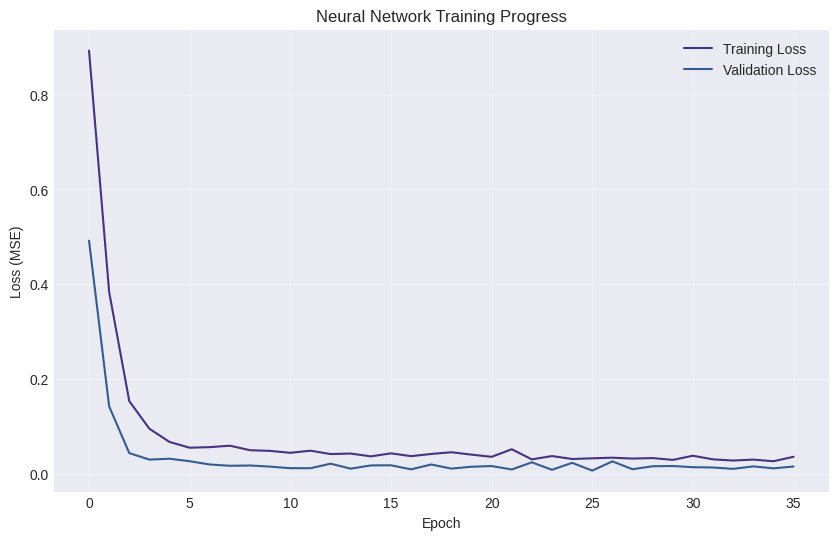

Final Validation Loss (MSE): 0.015112
Final Validation MAE: 0.096488

Computing feature importance from neural network weights...

Importance score distribution:
  0.10-max: 0 stocks
  0.08-0.1: 0 stocks
  0.06-0.08: 0 stocks
  0.04-0.06: 100 stocks
  0.02-0.04: 0 stocks
  0.00-0.02: 0 stocks

Top 15 stocks selected by neural network:
  1. TSLA: importance = 0.059266
  2. NFLX: importance = 0.058539
  3. PLTR: importance = 0.056789
  4. AVGO: importance = 0.055544
  5. VZ: importance = 0.055088
  6. COST: importance = 0.054935
  7. INTU: importance = 0.054826
  8. CHTR: importance = 0.054614
  9. CSCO: importance = 0.054524
  10. BA: importance = 0.054478
  11. TXN: importance = 0.054077
  12. C: importance = 0.053724
  13. TGT: importance = 0.053446
  14. MA: importance = 0.053391
  15. JPM: importance = 0.053349

Calculating correlation-based weights for selected stocks...
Correlations of selected stocks with index:
  C: 0.6465
  TXN: 0.6463
  INTU: 0.5859
  JPM: 0.5818
  MA: 0.5791


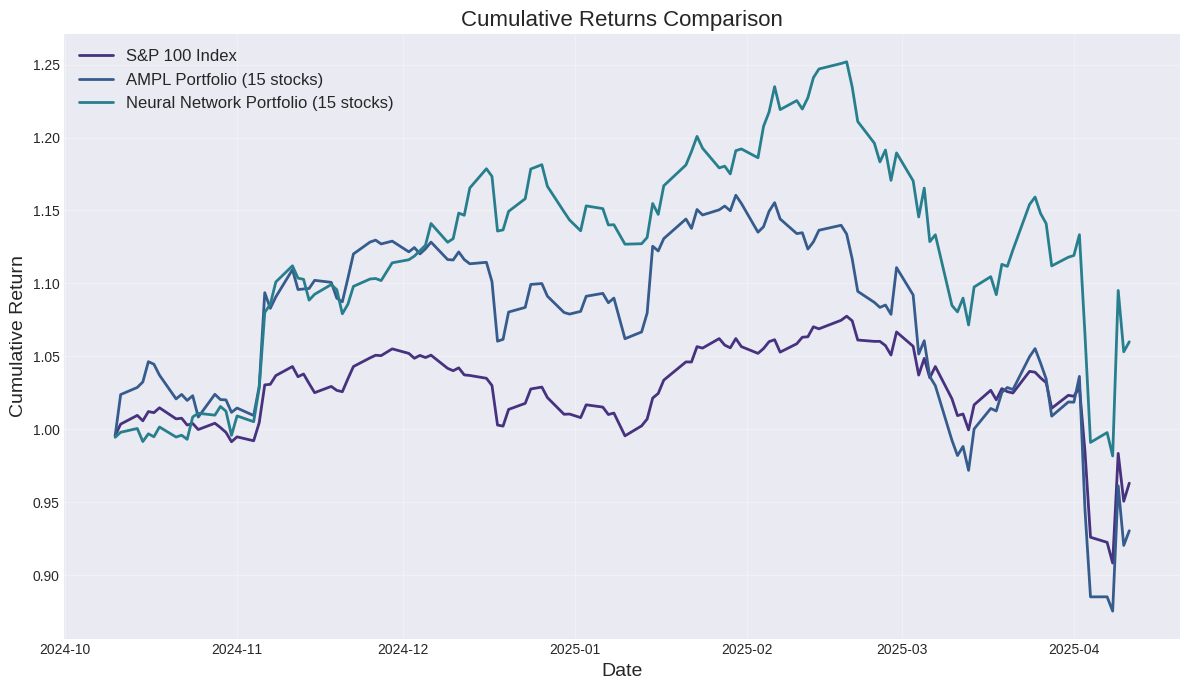

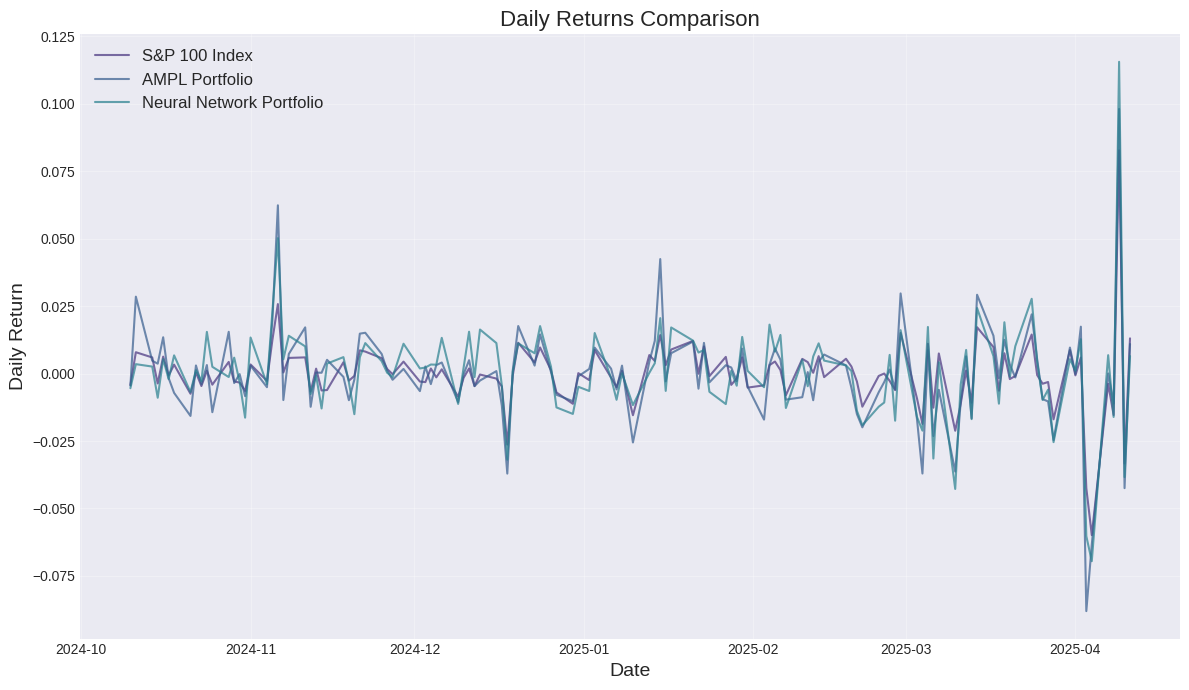


PORTFOLIO COMPOSITION ANALYSIS

Complete Stock Lists:

AMPL Portfolio (15 stocks):
    1. AXP  : 0.2000
    2. BAC  : 0.2000
    3. BLK  : 0.2000
    4. GS   : 0.2000
    5. HD   : 0.1000
    6. BK   : 0.0100
    7. C    : 0.0100
    8. CAT  : 0.0100
    9. HON  : 0.0100
   10. LOW  : 0.0100
   11. MET  : 0.0100
   12. MS   : 0.0100
   13. SPG  : 0.0100
   14. TXN  : 0.0100
   15. USB  : 0.0100

Neural Network Portfolio (15 stocks):
    1. C    : 0.0884
    2. TXN  : 0.0884
    3. INTU : 0.0801
    4. JPM  : 0.0796
    5. MA   : 0.0792
    6. CSCO : 0.0686
    7. PLTR : 0.0662
    8. AVGO : 0.0651
    9. TSLA : 0.0622
   10. COST : 0.0615
   11. CHTR : 0.0601
   12. BA   : 0.0573
   13. TGT  : 0.0569
   14. NFLX : 0.0480
   15. VZ   : 0.0384

Portfolio Concentration Statistics:
  AMPL Portfolio - Herfindahl Index: 0.1710
  Neural Network Portfolio - Herfindahl Index: 0.0695
  AMPL Portfolio - Top 5 stocks weight: 0.9000 (90.0%)
  Neural Network Portfolio - Top 5 stocks weight: 0.4158 

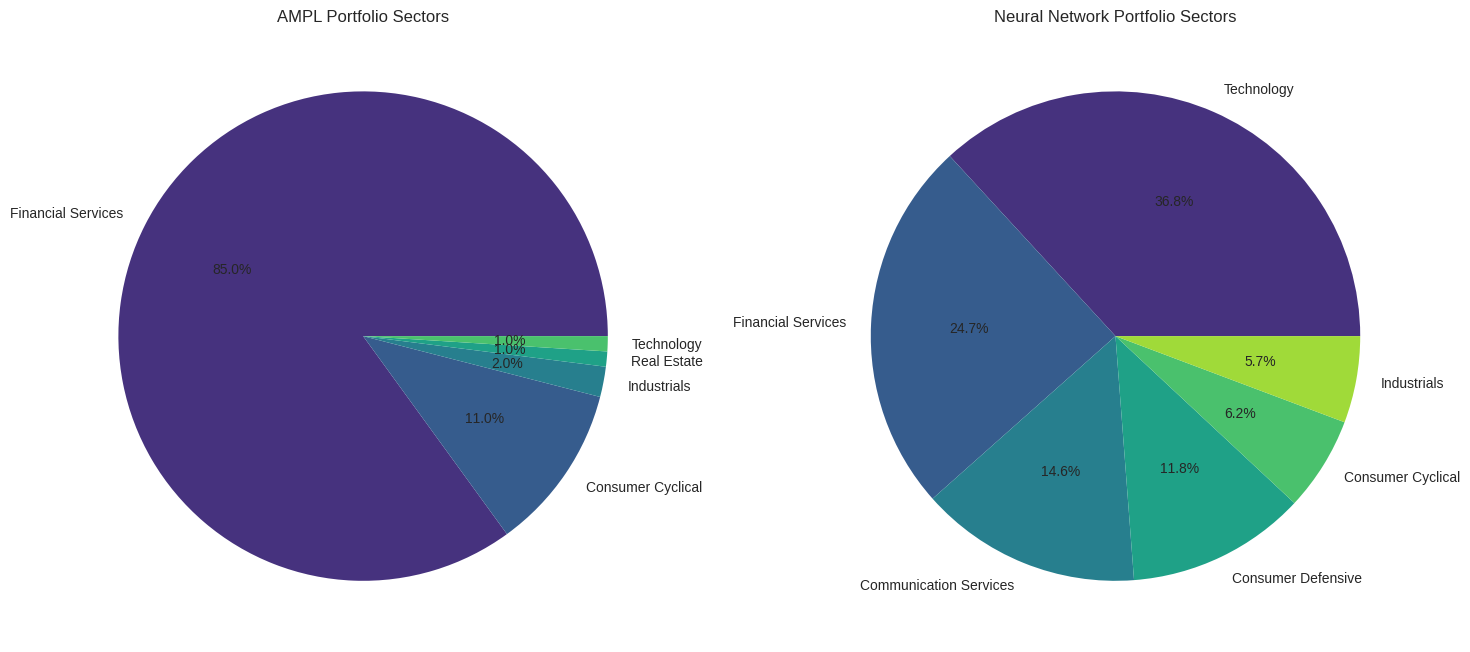


AMPL Portfolio - Stocks by Sector:
  Consumer Cyclical (2 stocks):
    HD: 0.1000 (90.9% of sector)
    LOW: 0.0100 (9.1% of sector)
  Financial Services (9 stocks):
    AXP: 0.2000 (23.5% of sector)
    BAC: 0.2000 (23.5% of sector)
    BLK: 0.2000 (23.5% of sector)
    GS: 0.2000 (23.5% of sector)
    BK: 0.0100 (1.2% of sector)
    C: 0.0100 (1.2% of sector)
    MET: 0.0100 (1.2% of sector)
    MS: 0.0100 (1.2% of sector)
    USB: 0.0100 (1.2% of sector)
  Industrials (2 stocks):
    CAT: 0.0100 (50.0% of sector)
    HON: 0.0100 (50.0% of sector)
  Real Estate (1 stocks):
    SPG: 0.0100 (100.0% of sector)
  Technology (1 stocks):
    TXN: 0.0100 (100.0% of sector)

Neural Network Portfolio - Stocks by Sector:
  Communication Services (3 stocks):
    CHTR: 0.0601 (41.0% of sector)
    NFLX: 0.0480 (32.8% of sector)
    VZ: 0.0384 (26.2% of sector)
  Consumer Cyclical (1 stocks):
    TSLA: 0.0622 (100.0% of sector)
  Consumer Defensive (2 stocks):
    COST: 0.0615 (51.9% of sector)


<Figure size 1200x800 with 0 Axes>

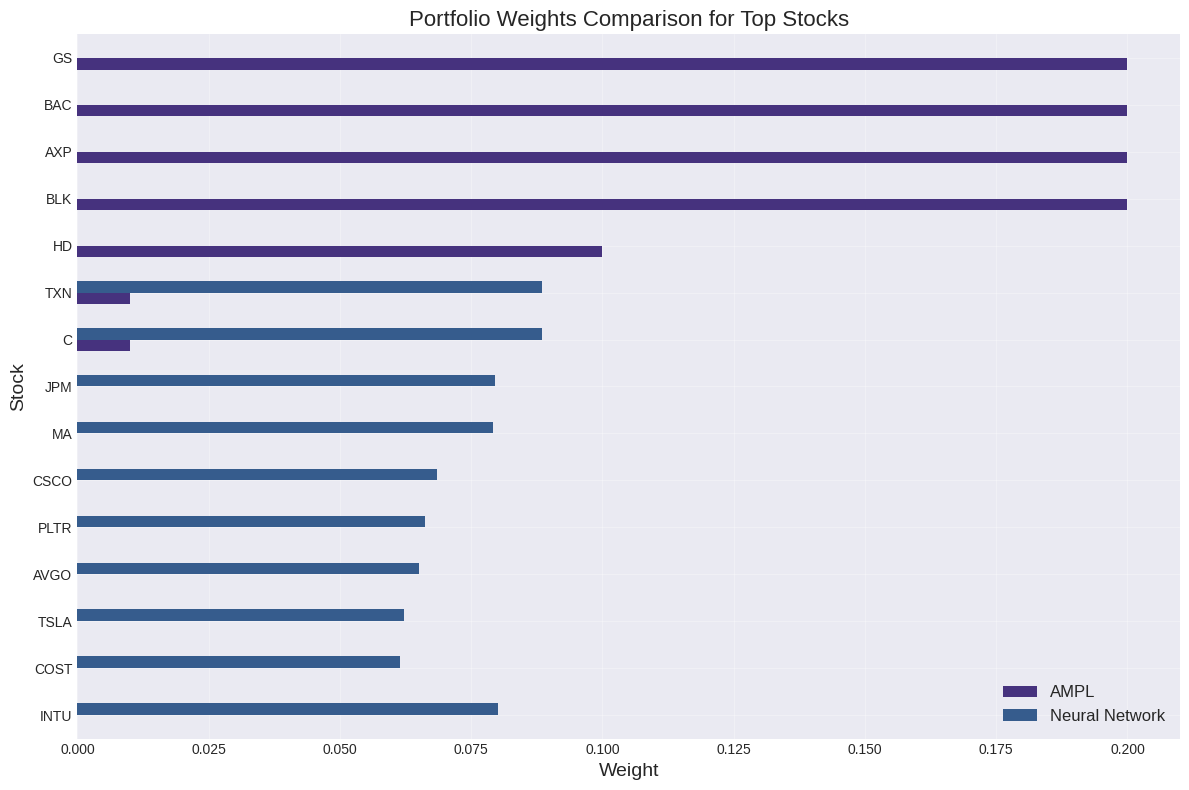


PARAMETER EXPLORATION: ANALYZING DIFFERENT Q VALUES

Testing q = 5 stocks
--------------------------------------------------

AMPL OPTIMIZATION: Finding optimal 5 stocks to track S&P 100
Using solver: cbc
Optimization model: Improved (with diversification)
Solving AMPL optimization model...
cbc 2.10.12: cbc 2.10.12: optimal solution; objective 0.683369494
0 simplex iterations
Solve result: solved
AMPL optimization selected 5 stocks
Top stocks with weights:
  AXP: 0.2000
  BAC: 0.2000
  BLK: 0.2000
  GS: 0.2000
  HD: 0.2000
Portfolio concentration (Herfindahl Index): 0.2000
Weight of largest position: 0.2000

NEURAL NETWORK APPROACH: Identifying 5 stocks to track S&P 100
Preparing data for neural network training...
Input shape: (376, 100), Target shape: (376, 1)
Standardizing data...
Splitting data into training and validation sets (80/20)...
Training data shape: (300, 100), Validation data shape: (76, 100)
Converting data to PyTorch tensors on cuda:0...
Creating DataLoad

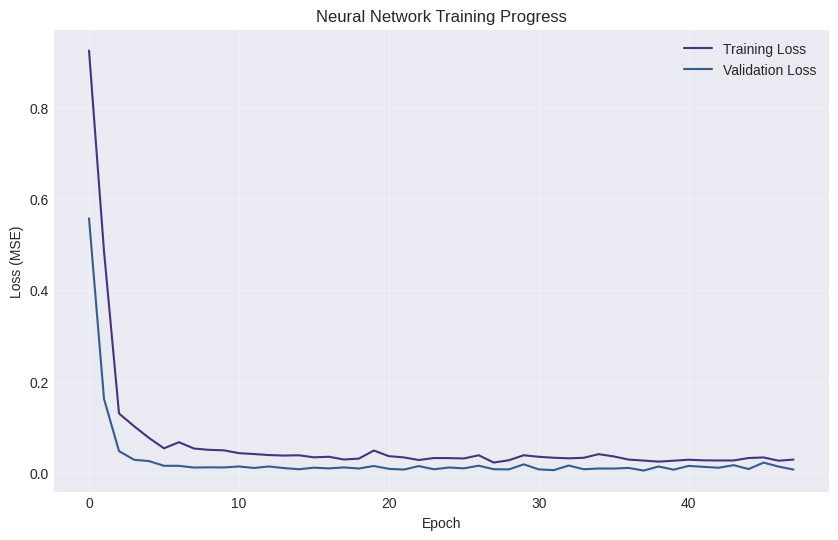

Final Validation Loss (MSE): 0.007450
Final Validation MAE: 0.067144

Computing feature importance from neural network weights...

Importance score distribution:
  0.10-max: 0 stocks
  0.08-0.1: 0 stocks
  0.06-0.08: 1 stocks
  0.04-0.06: 99 stocks
  0.02-0.04: 0 stocks
  0.00-0.02: 0 stocks

Top 5 stocks selected by neural network:
  1. PLTR: importance = 0.062825
  2. NOW: importance = 0.058504
  3. AVGO: importance = 0.058342
  4. TSLA: importance = 0.057501
  5. INTC: importance = 0.056045

Calculating correlation-based weights for selected stocks...
Correlations of selected stocks with index:
  PLTR: 0.4841
  AVGO: 0.4757
  NOW: 0.4737
  INTC: 0.4578
  TSLA: 0.4551

Final neural network portfolio weights:
  1. PLTR: weight = 0.2498
  2. NOW: weight = 0.2482
  3. AVGO: weight = 0.2475
  4. INTC: weight = 0.1483
  5. TSLA: weight = 0.1061
Portfolio concentration (Herfindahl Index): 0.2185
Weight of largest position: 0.2498

PERFORMANCE EVALUATION

Evaluating portfolios on test data.

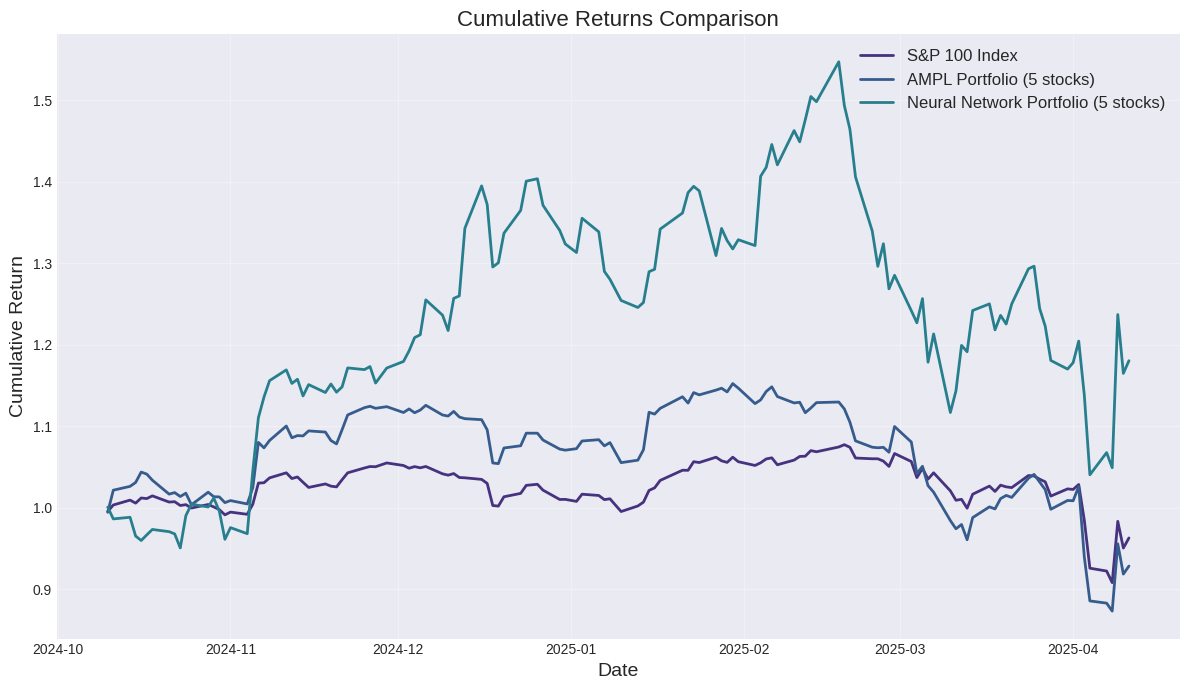

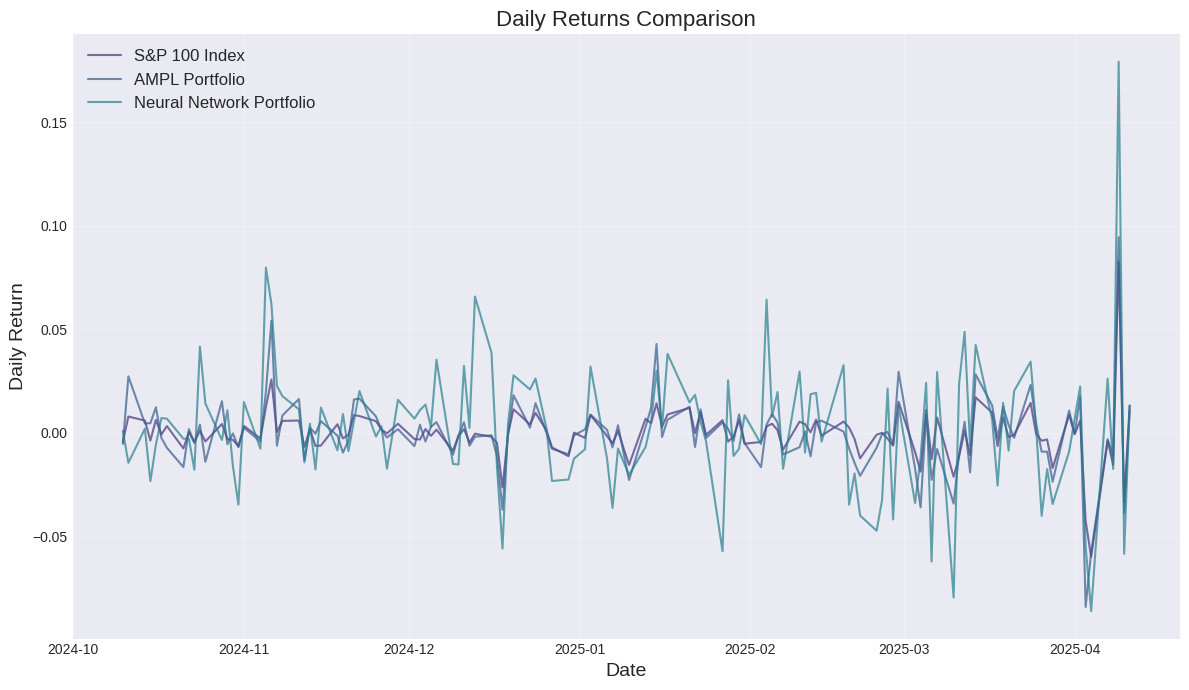


Testing q = 10 stocks
--------------------------------------------------

AMPL OPTIMIZATION: Finding optimal 10 stocks to track S&P 100
Using solver: cbc
Optimization model: Improved (with diversification)
Solving AMPL optimization model...
cbc 2.10.12: cbc 2.10.12: optimal solution; objective 0.6827954416
0 simplex iterations
Solve result: solved
AMPL optimization selected 10 stocks
Top stocks with weights:
  AXP: 0.2000
  BAC: 0.2000
  BLK: 0.2000
  GS: 0.2000
  HD: 0.1500
  C: 0.0100
  LOW: 0.0100
  MS: 0.0100
  TXN: 0.0100
  USB: 0.0100
Portfolio concentration (Herfindahl Index): 0.1830
Weight of largest position: 0.2000

NEURAL NETWORK APPROACH: Identifying 10 stocks to track S&P 100
Preparing data for neural network training...
Input shape: (376, 100), Target shape: (376, 1)
Standardizing data...
Splitting data into training and validation sets (80/20)...
Training data shape: (300, 100), Validation data shape: (76, 100)
Converting data to PyTorch tensors on cuda:0..

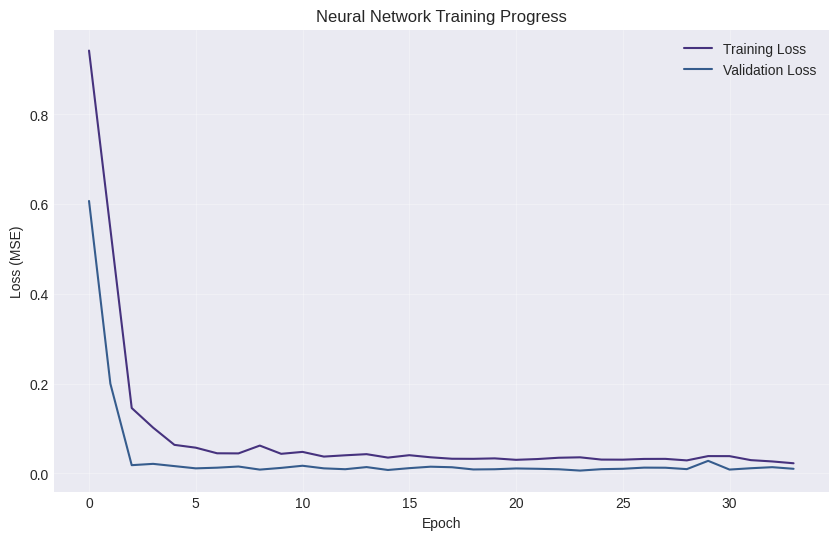

Final Validation Loss (MSE): 0.010106
Final Validation MAE: 0.077672

Computing feature importance from neural network weights...

Importance score distribution:
  0.10-max: 0 stocks
  0.08-0.1: 0 stocks
  0.06-0.08: 0 stocks
  0.04-0.06: 100 stocks
  0.02-0.04: 0 stocks
  0.00-0.02: 0 stocks

Top 10 stocks selected by neural network:
  1. QCOM: importance = 0.057793
  2. TXN: importance = 0.057090
  3. AVGO: importance = 0.057070
  4. PLTR: importance = 0.056518
  5. MMM: importance = 0.056414
  6. GILD: importance = 0.055697
  7. AMD: importance = 0.055095
  8. NFLX: importance = 0.054814
  9. TSLA: importance = 0.054770
  10. LLY: importance = 0.054668

Calculating correlation-based weights for selected stocks...
Correlations of selected stocks with index:
  TXN: 0.6463
  QCOM: 0.5138
  PLTR: 0.4841
  AVGO: 0.4757
  TSLA: 0.4551
  MMM: 0.4468
  AMD: 0.4363
  NFLX: 0.3508
  GILD: 0.3070
  LLY: 0.2072

Final neural network portfolio weights:
  1. TXN: weight = 0.1495
  2. QCOM: weight

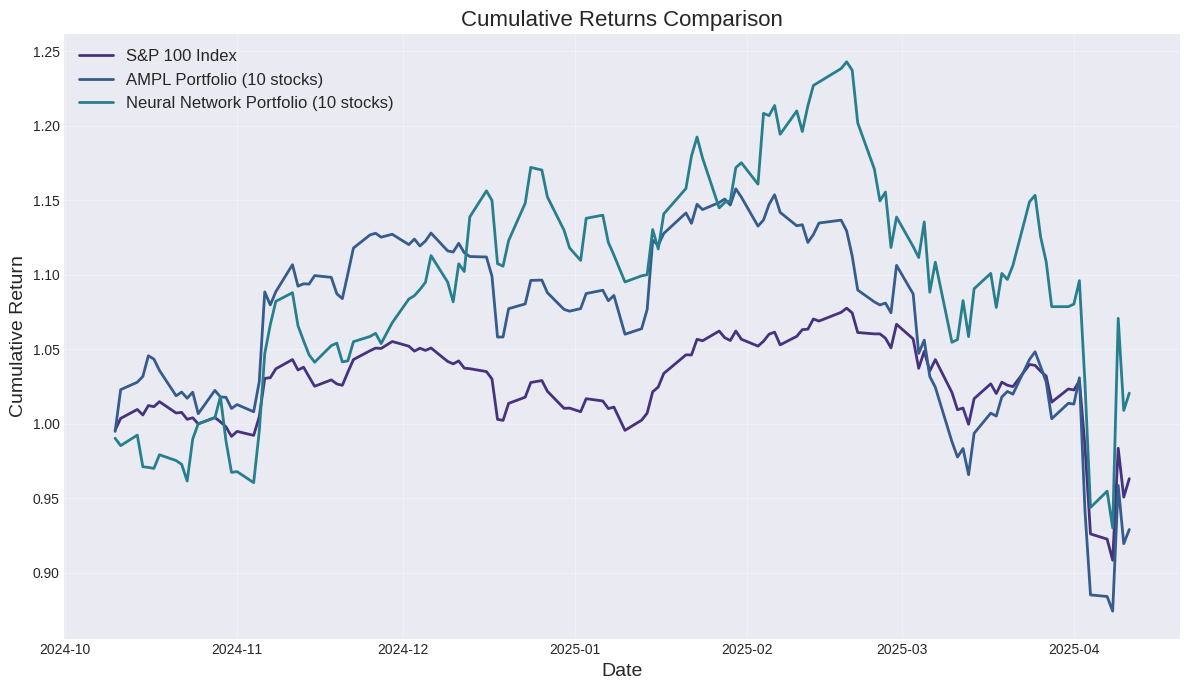

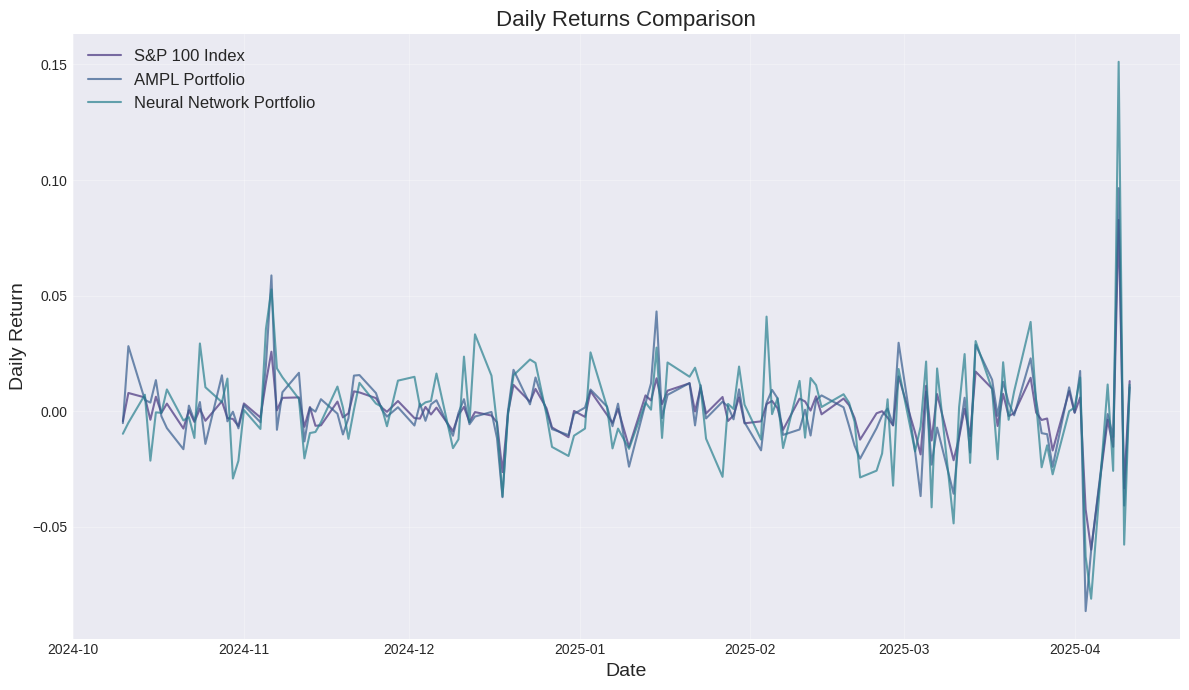


Testing q = 15 stocks
--------------------------------------------------

AMPL OPTIMIZATION: Finding optimal 15 stocks to track S&P 100
Using solver: cbc
Optimization model: Improved (with diversification)
Solving AMPL optimization model...
cbc 2.10.12: cbc 2.10.12: optimal solution; objective 0.6803047209
0 simplex iterations
Solve result: solved
AMPL optimization selected 15 stocks
Top stocks with weights:
  AXP: 0.2000
  BAC: 0.2000
  BLK: 0.2000
  GS: 0.2000
  HD: 0.1000
  BK: 0.0100
  C: 0.0100
  CAT: 0.0100
  HON: 0.0100
  LOW: 0.0100
Portfolio concentration (Herfindahl Index): 0.1710
Weight of largest position: 0.2000

NEURAL NETWORK APPROACH: Identifying 15 stocks to track S&P 100
Preparing data for neural network training...
Input shape: (376, 100), Target shape: (376, 1)
Standardizing data...
Splitting data into training and validation sets (80/20)...
Training data shape: (300, 100), Validation data shape: (76, 100)
Converting data to PyTorch tensors on cuda:0..

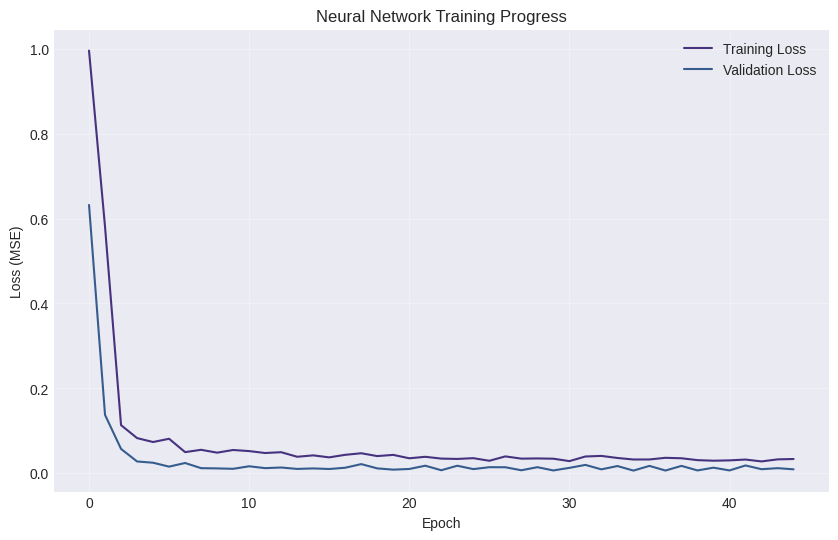

Final Validation Loss (MSE): 0.008950
Final Validation MAE: 0.068668

Computing feature importance from neural network weights...

Importance score distribution:
  0.10-max: 0 stocks
  0.08-0.1: 0 stocks
  0.06-0.08: 0 stocks
  0.04-0.06: 100 stocks
  0.02-0.04: 0 stocks
  0.00-0.02: 0 stocks

Top 15 stocks selected by neural network:
  1. PLTR: importance = 0.058003
  2. AMD: importance = 0.057603
  3. PYPL: importance = 0.056400
  4. SBUX: importance = 0.055106
  5. TXN: importance = 0.054727
  6. AAPL: importance = 0.054447
  7. TGT: importance = 0.054402
  8. ORCL: importance = 0.054293
  9. JNJ: importance = 0.053675
  10. AVGO: importance = 0.053592
  11. BMY: importance = 0.053571
  12. MSFT: importance = 0.053481
  13. NEE: importance = 0.053436
  14. QCOM: importance = 0.053404
  15. COF: importance = 0.053011

Calculating correlation-based weights for selected stocks...
Correlations of selected stocks with index:
  TXN: 0.6463
  COF: 0.5646
  PYPL: 0.5425
  QCOM: 0.5138
  PLT

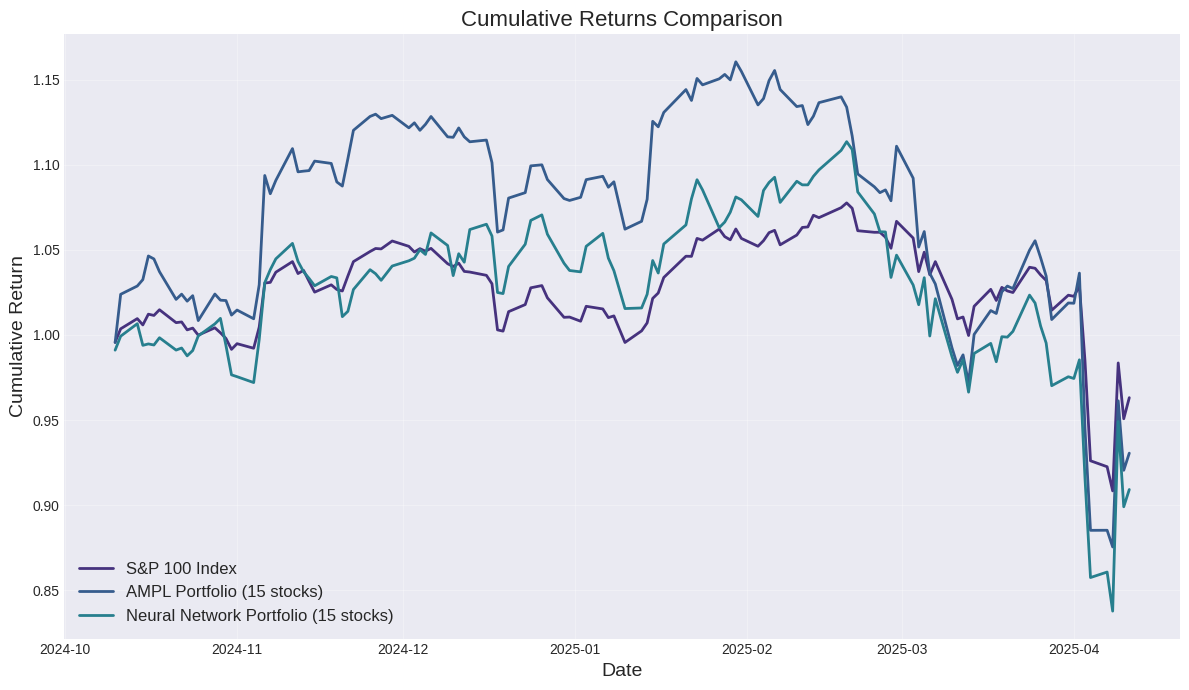

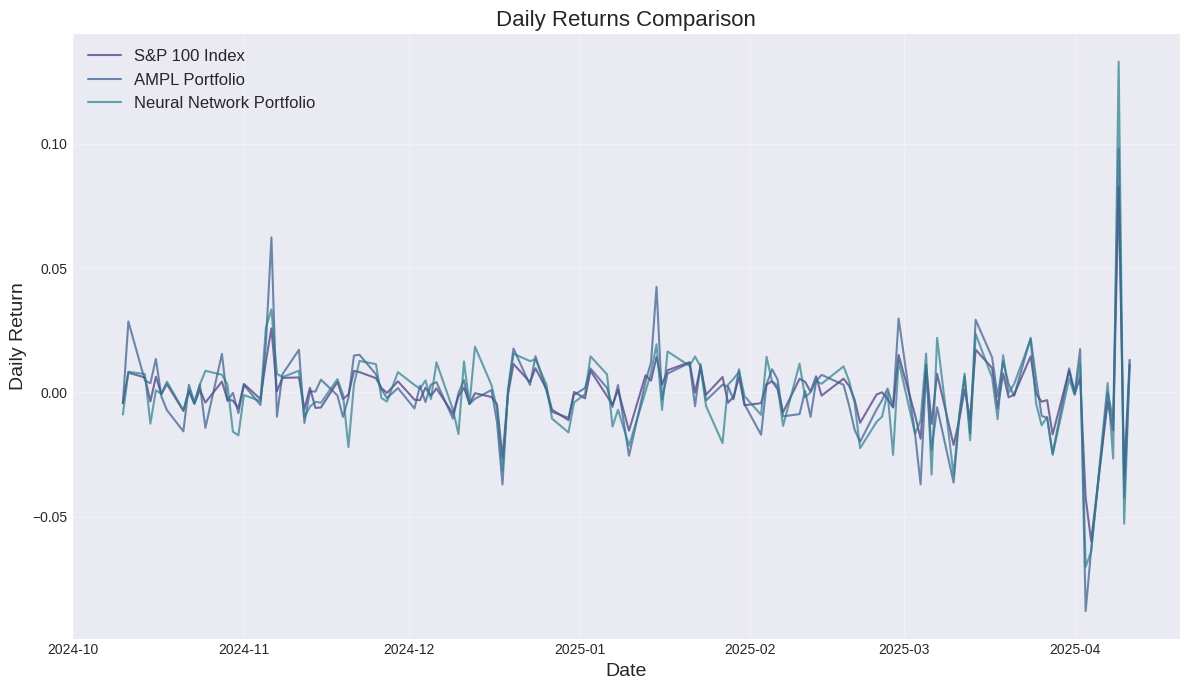


Testing q = 20 stocks
--------------------------------------------------

AMPL OPTIMIZATION: Finding optimal 20 stocks to track S&P 100
Using solver: cbc
Optimization model: Improved (with diversification)
Solving AMPL optimization model...
cbc 2.10.12: cbc 2.10.12: optimal solution; objective 0.6760435957
0 simplex iterations
Solve result: solved
AMPL optimization selected 20 stocks
Top stocks with weights:
  AXP: 0.2000
  BAC: 0.2000
  BLK: 0.2000
  GS: 0.2000
  HD: 0.0500
  AIG: 0.0100
  BK: 0.0100
  C: 0.0100
  CAT: 0.0100
  COF: 0.0100
Portfolio concentration (Herfindahl Index): 0.1640
Weight of largest position: 0.2000

NEURAL NETWORK APPROACH: Identifying 20 stocks to track S&P 100
Preparing data for neural network training...
Input shape: (376, 100), Target shape: (376, 1)
Standardizing data...
Splitting data into training and validation sets (80/20)...
Training data shape: (300, 100), Validation data shape: (76, 100)
Converting data to PyTorch tensors on cuda:0..

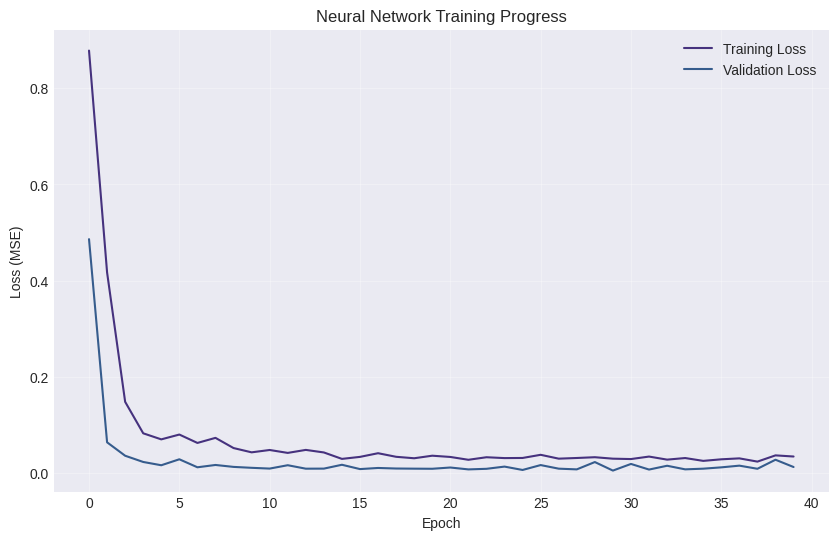

Final Validation Loss (MSE): 0.012606
Final Validation MAE: 0.083291

Computing feature importance from neural network weights...

Importance score distribution:
  0.10-max: 0 stocks
  0.08-0.1: 0 stocks
  0.06-0.08: 0 stocks
  0.04-0.06: 99 stocks
  0.02-0.04: 1 stocks
  0.00-0.02: 0 stocks

Top 20 stocks selected by neural network:
  1. TSLA: importance = 0.058087
  2. PLTR: importance = 0.057815
  3. AMD: importance = 0.056947
  4. ORCL: importance = 0.056883
  5. META: importance = 0.056162
  6. ADBE: importance = 0.055565
  7. GE: importance = 0.055215
  8. MMM: importance = 0.054644
  9. CAT: importance = 0.054587
  10. HD: importance = 0.053976
  11. INTC: importance = 0.053515
  12. TGT: importance = 0.053241
  13. NVDA: importance = 0.053134
  14. CHTR: importance = 0.053075
  15. CL: importance = 0.053034
  16. AVGO: importance = 0.053034
  17. DIS: importance = 0.053030
  18. BK: importance = 0.052968
  19. QCOM: importance = 0.052831
  20. GOOG: importance = 0.052513

Calcu

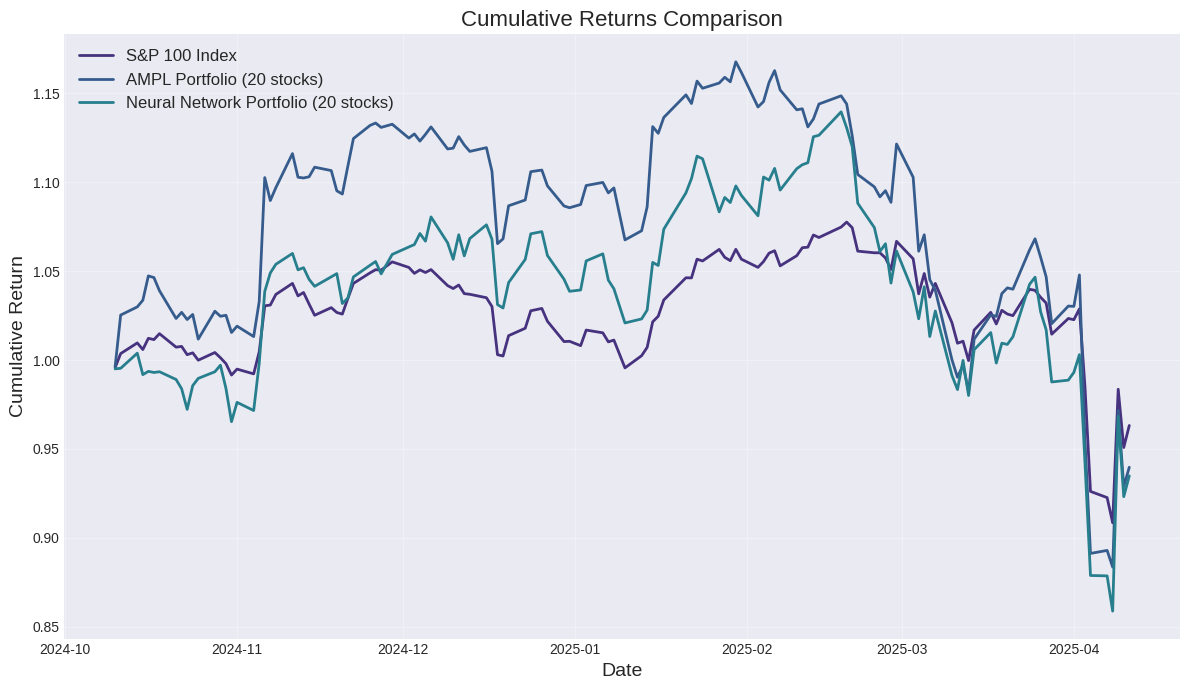

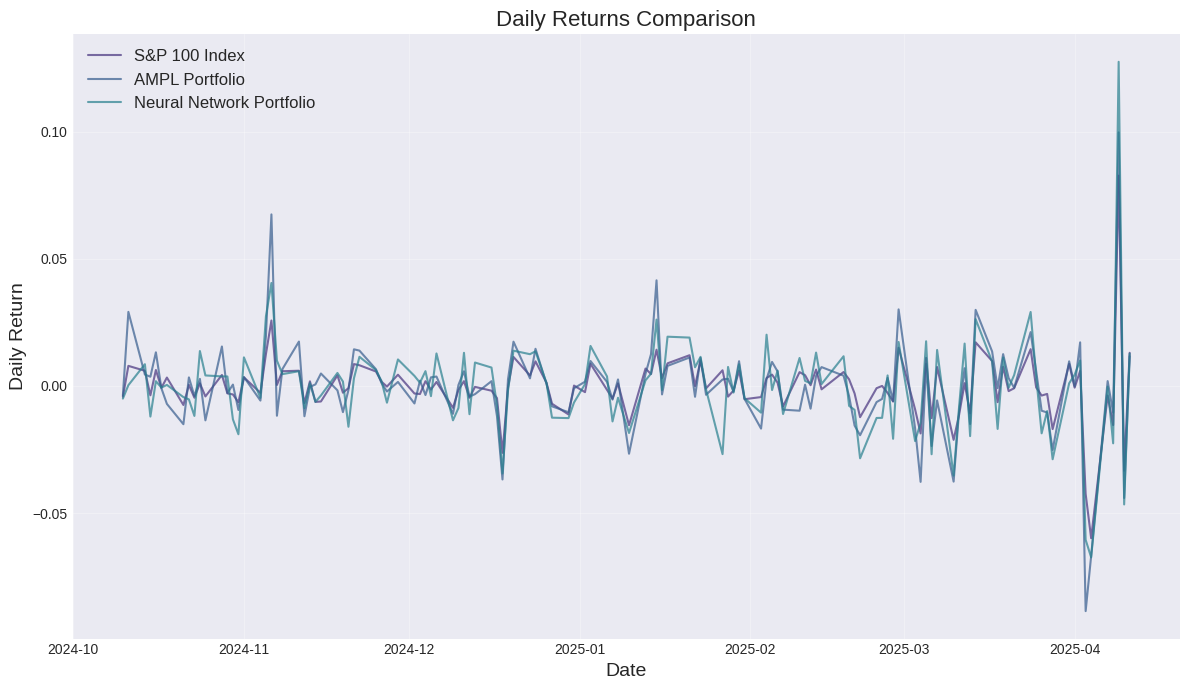


Testing q = 25 stocks
--------------------------------------------------

AMPL OPTIMIZATION: Finding optimal 25 stocks to track S&P 100
Using solver: cbc
Optimization model: Improved (with diversification)
Solving AMPL optimization model...
cbc 2.10.12: cbc 2.10.12: optimal solution; objective 0.6704418022
0 simplex iterations
Solve result: solved
AMPL optimization selected 25 stocks
Top stocks with weights:
  BAC: 0.2000
  BLK: 0.2000
  GS: 0.2000
  AXP: 0.1900
  AIG: 0.0100
  BK: 0.0100
  C: 0.0100
  CAT: 0.0100
  COF: 0.0100
  EMR: 0.0100
Portfolio concentration (Herfindahl Index): 0.1582
Weight of largest position: 0.2000

NEURAL NETWORK APPROACH: Identifying 25 stocks to track S&P 100
Preparing data for neural network training...
Input shape: (376, 100), Target shape: (376, 1)
Standardizing data...
Splitting data into training and validation sets (80/20)...
Training data shape: (300, 100), Validation data shape: (76, 100)
Converting data to PyTorch tensors on cuda:0.

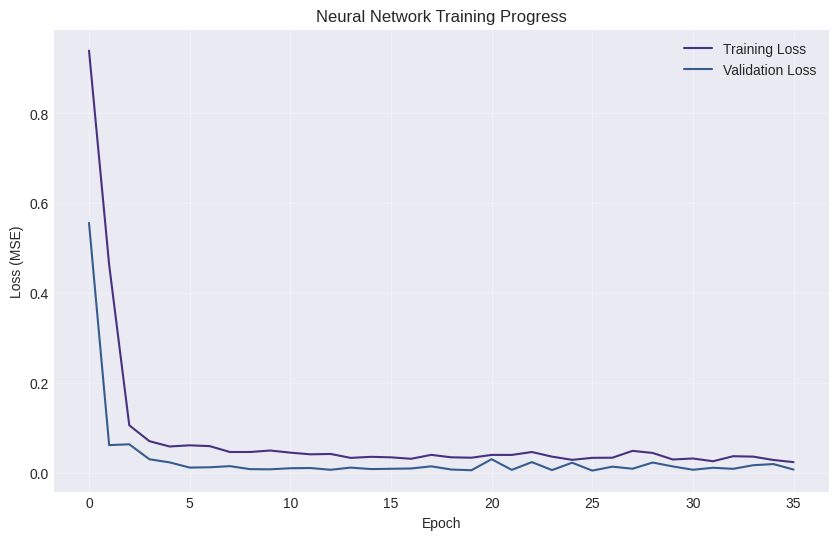

Final Validation Loss (MSE): 0.008073
Final Validation MAE: 0.070982

Computing feature importance from neural network weights...

Importance score distribution:
  0.10-max: 0 stocks
  0.08-0.1: 0 stocks
  0.06-0.08: 0 stocks
  0.04-0.06: 100 stocks
  0.02-0.04: 0 stocks
  0.00-0.02: 0 stocks

Top 25 stocks selected by neural network:
  1. TMO: importance = 0.058782
  2. PLTR: importance = 0.058049
  3. AMD: importance = 0.057604
  4. CMCSA: importance = 0.057043
  5. AXP: importance = 0.056627
  6. TSLA: importance = 0.056364
  7. NVDA: importance = 0.056144
  8. GS: importance = 0.055397
  9. ISRG: importance = 0.055050
  10. GOOG: importance = 0.054846
  11. JPM: importance = 0.054138
  12. BA: importance = 0.053862
  13. COP: importance = 0.053847
  14. MET: importance = 0.053834
  15. LMT: importance = 0.053759
  16. TXN: importance = 0.053712
  17. INTC: importance = 0.053673
  18. VZ: importance = 0.053045
  19. NFLX: importance = 0.052989
  20. PYPL: importance = 0.052983
  21.

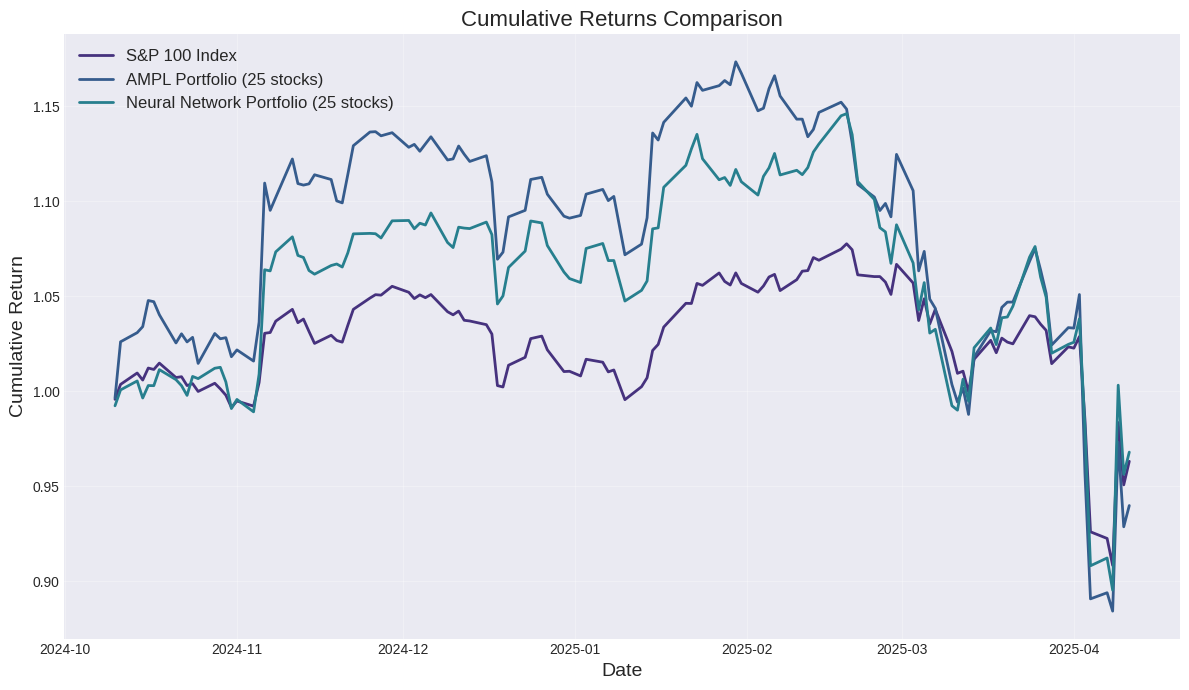

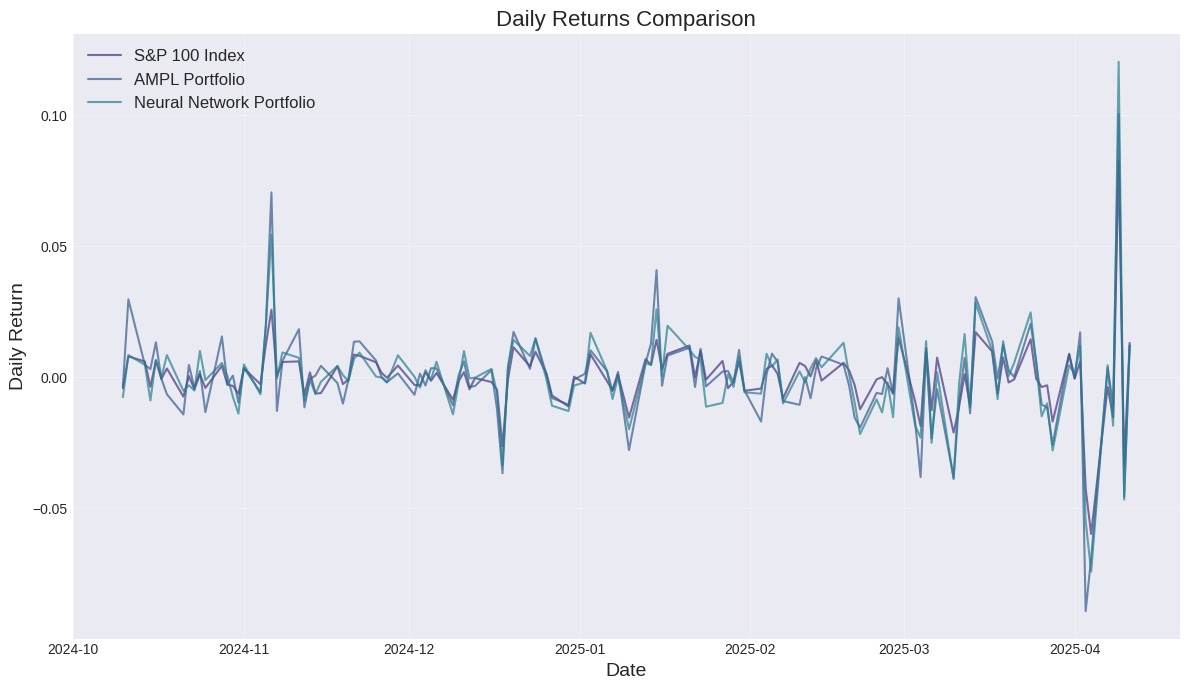


SUMMARY OF RESULTS ACROSS DIFFERENT Q VALUES

Tracking Error (lower is better):
Q Value    AMPL            Neural Network  Winner    
--------------------------------------------------
5          0.1306          0.3827          AMPL      
10         0.1362          0.2348          AMPL      
15         0.1395          0.1464          AMPL      
20         0.1448          0.1459          AMPL      
25         0.1488          0.1172          NN        

Correlation with Index (higher is better):
Q Value    AMPL            Neural Network  Winner    
--------------------------------------------------
5          0.9207          0.7563          AMPL      
10         0.9209          0.8676          AMPL      
15         0.9225          0.9252          NN        
20         0.9215          0.9255          NN        
25         0.9210          0.9566          NN        

Annualized Return (higher is better):
Q Value    AMPL            Neural Network  Winner    
--------------------------------

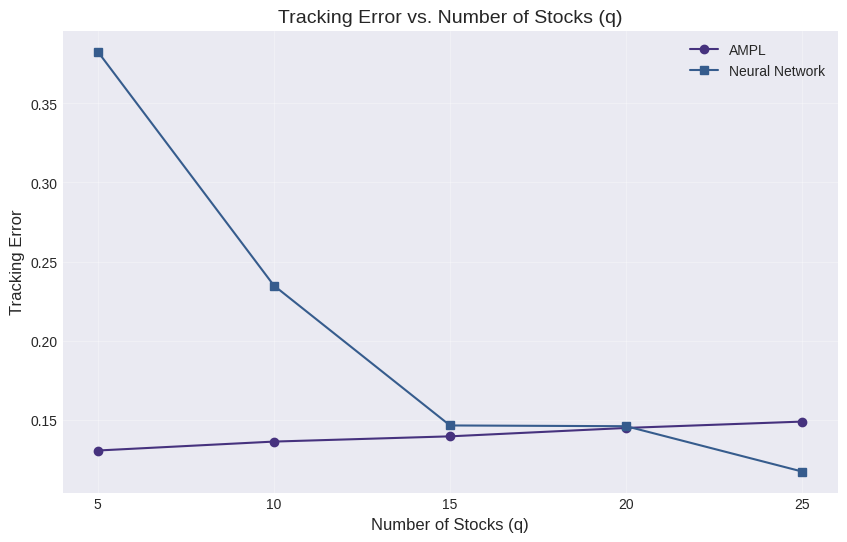

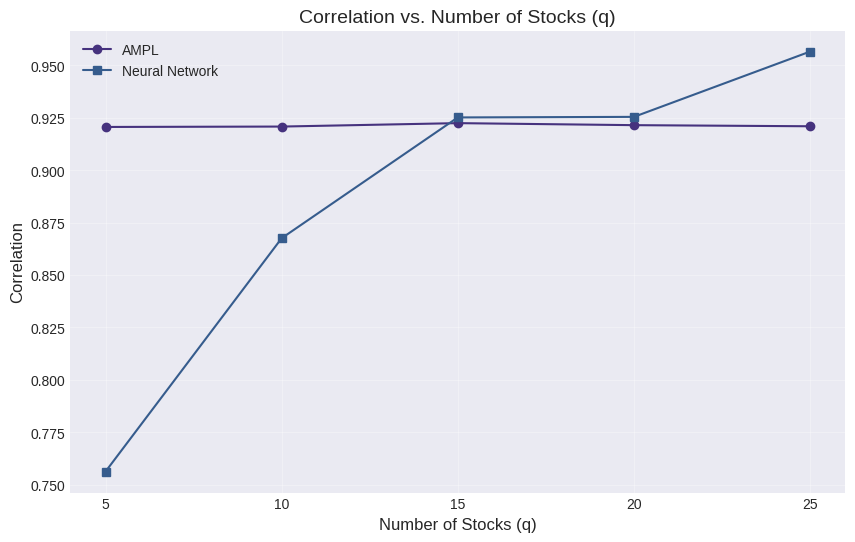

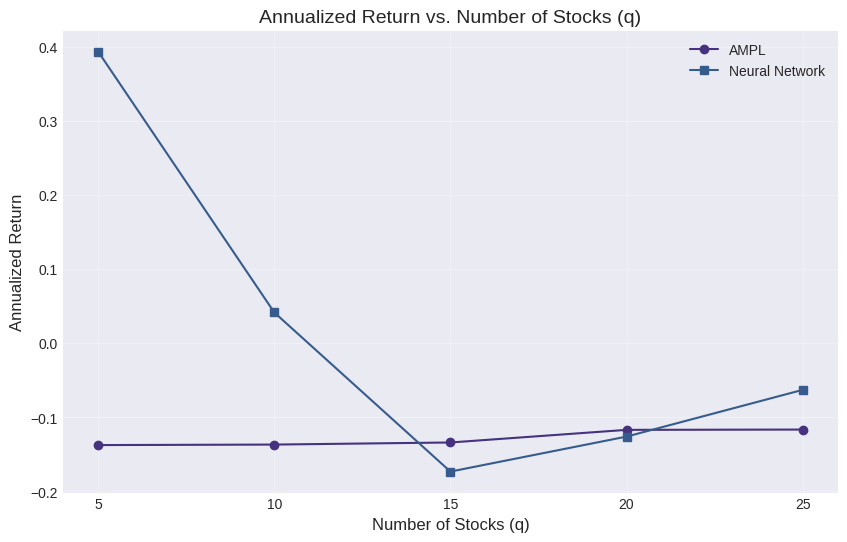


Optimal q values based on minimizing tracking error:
  AMPL: q = 5
  Neural Network: q = 25

Recommendations based on parameter exploration:
AMPL approach works best with q = 5 stocks.
Neural Network approach works best with q = 25 stocks.
Overall, Neural Network with q = 25 provides the lowest tracking error (0.1172).

Additional insights on parameter selection:
1. Trade-offs between q value and tracking performance:
   - For AMPL: Tracking error consistently increases with more stocks
   - For Neural Network: Tracking error consistently decreases with more stocks
2. Practical considerations:
   - Larger q values may increase transaction costs and portfolio management complexity
   - Smaller q values simplify portfolio management but may sacrifice tracking accuracy
   - The optimal q value balances tracking performance with practical implementation concerns

TIME HORIZON ANALYSIS: TESTING PERFORMANCE ACROSS DIFFERENT PERIODS

Testing time horizon: 3mo
--------------------------------

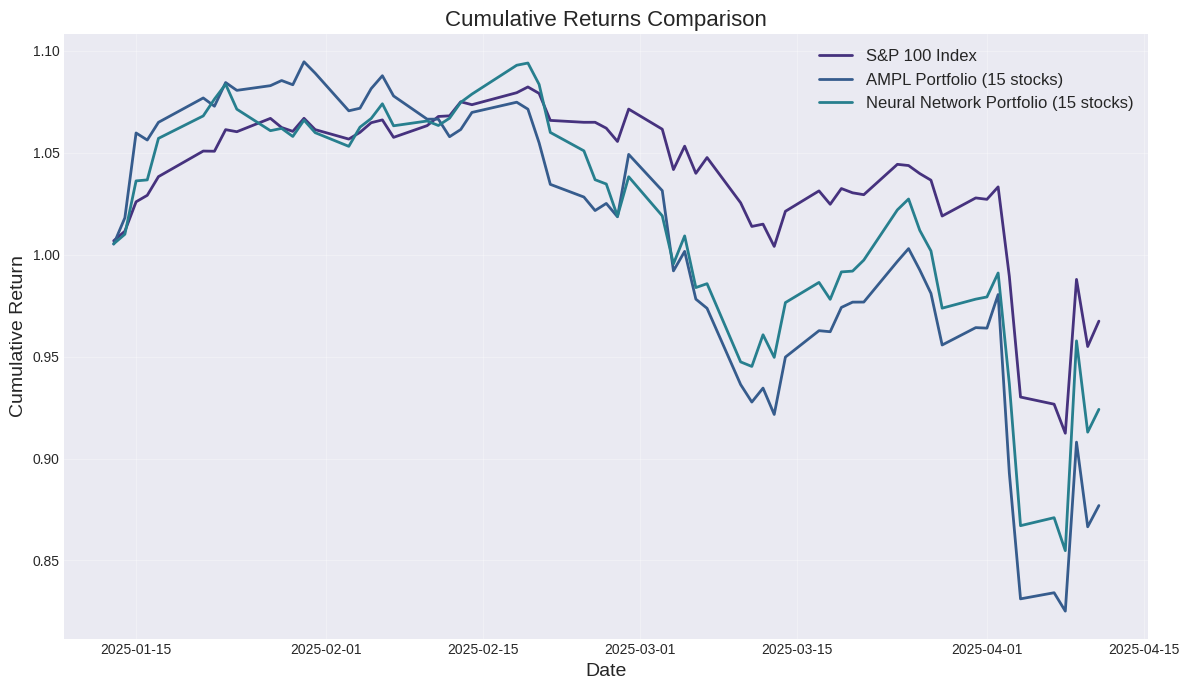

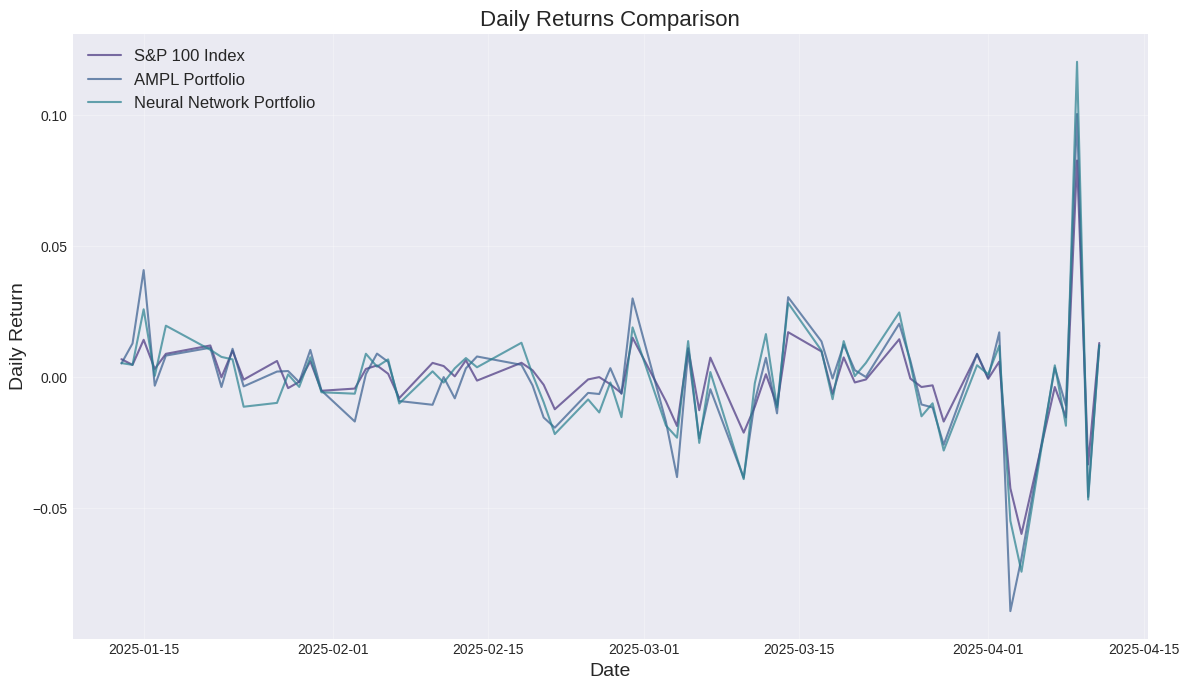


Testing time horizon: 6mo
--------------------------------------------------
Using 126 trading days for 6mo test period
Split data into 376 training days and 126 testing days

PERFORMANCE EVALUATION
Test Period: 6mo

Evaluating portfolios on test data...
Test period: 2024-10-10 to 2025-04-11 (126 trading days)

AMPL Portfolio: 25 stocks
Stocks: AIG, AXP, BAC, BK, BLK and more...

Neural Network Portfolio: 25 stocks
Stocks: TMO, PLTR, AMD, CMCSA, AXP and more...

Calculating portfolio returns on test data...

Basic Return Statistics:
Mean Daily Returns:
  S&P 100 Index: -0.0215%
  AMPL Portfolio: -0.0297%
  Neural Network: -0.0086%
Daily Return Volatility:
  S&P 100 Index: 1.2954%
  AMPL Portfolio: 1.9833%
  Neural Network: 1.8741%
Cumulative Returns over Test Period:
  S&P 100 Index: -3.68%
  AMPL Portfolio: -6.01%
  Neural Network: -3.20%

Calculating detailed performance metrics...

Detailed Performance Metrics:
Metric               AMPL            Neural Network  Difference     
--

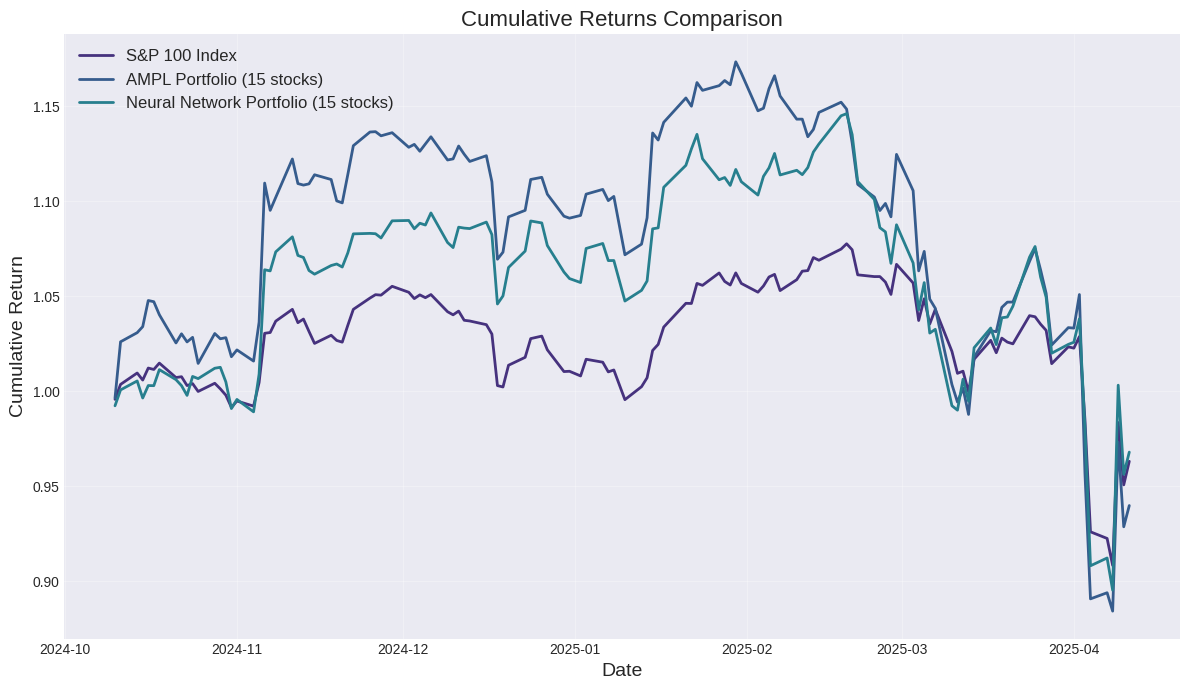

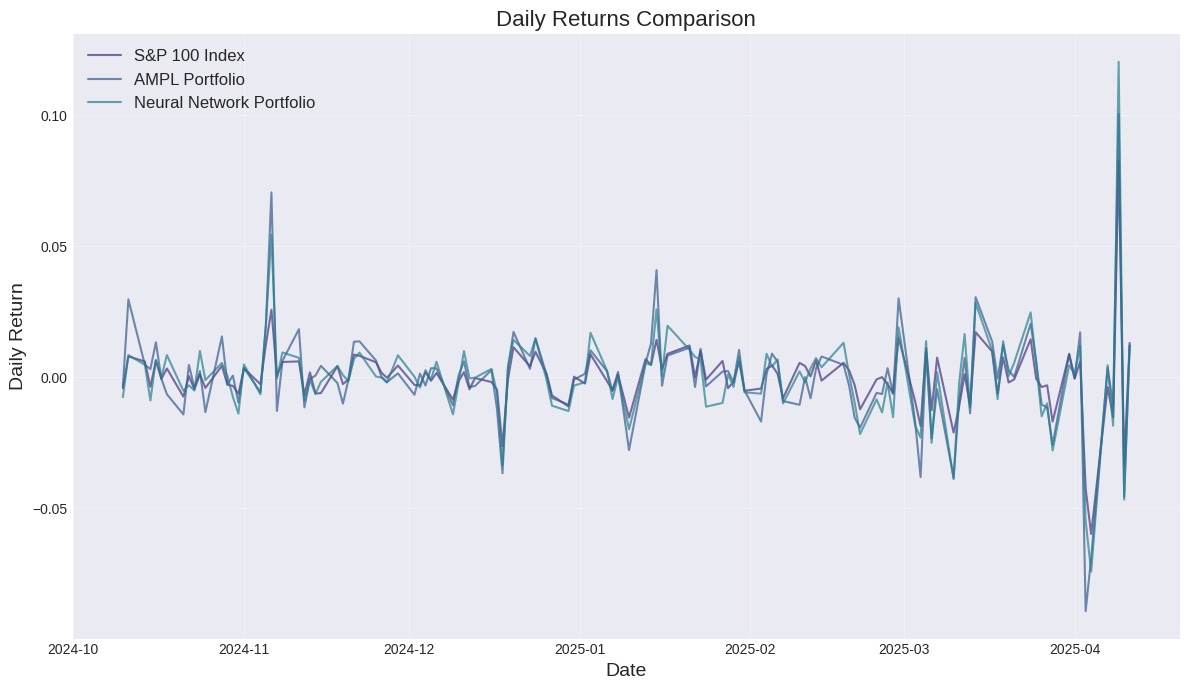


Testing time horizon: 9mo
--------------------------------------------------
Using 189 trading days for 9mo test period
Split data into 313 training days and 189 testing days

PERFORMANCE EVALUATION
Test Period: 9mo

Evaluating portfolios on test data...
Test period: 2024-07-12 to 2025-04-11 (189 trading days)

AMPL Portfolio: 25 stocks
Stocks: AIG, AXP, BAC, BK, BLK and more...

Neural Network Portfolio: 25 stocks
Stocks: TMO, PLTR, AMD, CMCSA, AXP and more...

Calculating portfolio returns on test data...

Basic Return Statistics:
Mean Daily Returns:
  S&P 100 Index: 0.0316%
  AMPL Portfolio: 0.0260%
  Neural Network: 0.0370%
Daily Return Volatility:
  S&P 100 Index: 1.1655%
  AMPL Portfolio: 1.7792%
  Neural Network: 1.7050%
Cumulative Returns over Test Period:
  S&P 100 Index: 4.82%
  AMPL Portfolio: 1.96%
  Neural Network: 4.39%

Calculating detailed performance metrics...

Detailed Performance Metrics:
Metric               AMPL            Neural Network  Difference     
--------

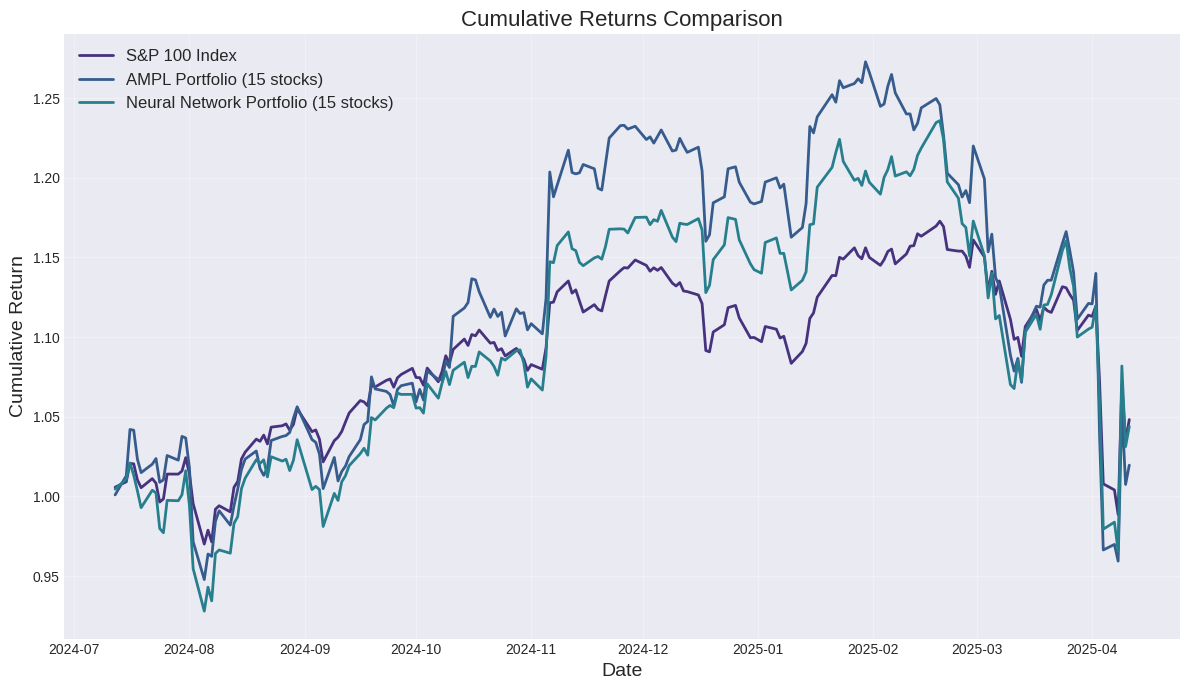

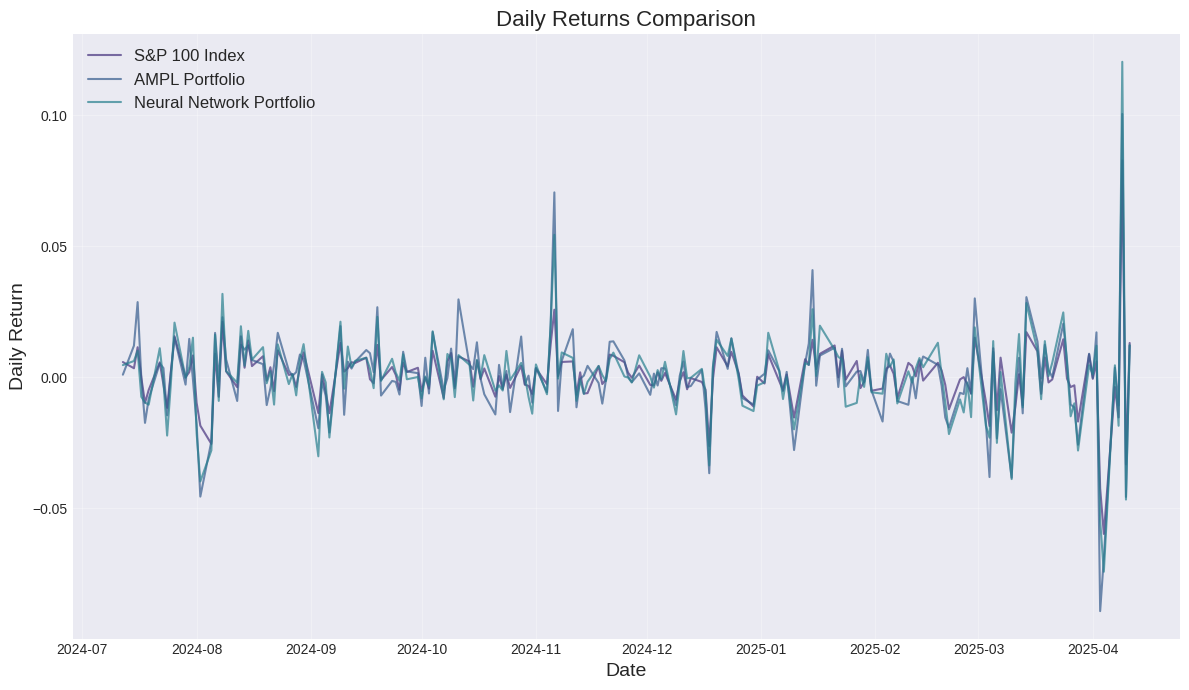


Testing time horizon: 1y
--------------------------------------------------
Using 251 trading days for 1y test period
Split data into 251 training days and 251 testing days

PERFORMANCE EVALUATION
Test Period: 1y

Evaluating portfolios on test data...
Test period: 2024-04-12 to 2025-04-11 (251 trading days)

AMPL Portfolio: 25 stocks
Stocks: AIG, AXP, BAC, BK, BLK and more...

Neural Network Portfolio: 25 stocks
Stocks: TMO, PLTR, AMD, CMCSA, AXP and more...

Calculating portfolio returns on test data...

Basic Return Statistics:
Mean Daily Returns:
  S&P 100 Index: 0.0446%
  AMPL Portfolio: 0.0626%
  Neural Network: 0.0664%
Daily Return Volatility:
  S&P 100 Index: 1.0456%
  AMPL Portfolio: 1.6085%
  Neural Network: 1.5204%
Cumulative Returns over Test Period:
  S&P 100 Index: 10.34%
  AMPL Portfolio: 13.29%
  Neural Network: 14.81%

Calculating detailed performance metrics...

Detailed Performance Metrics:
Metric               AMPL            Neural Network  Difference     
--------

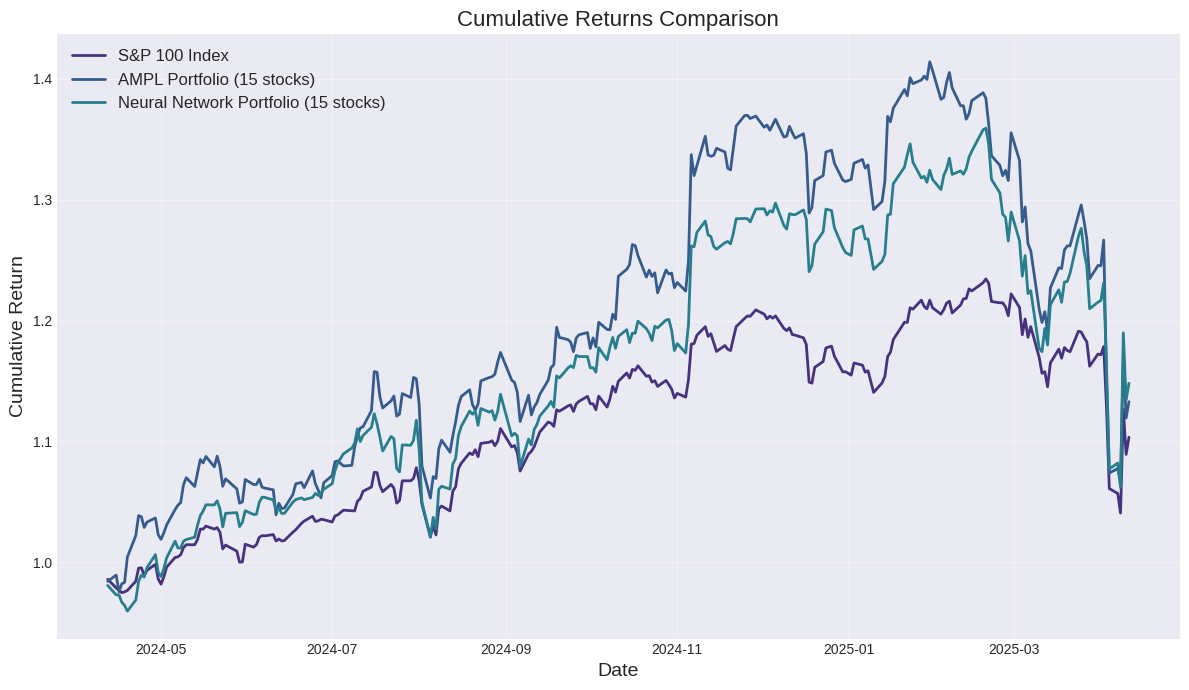

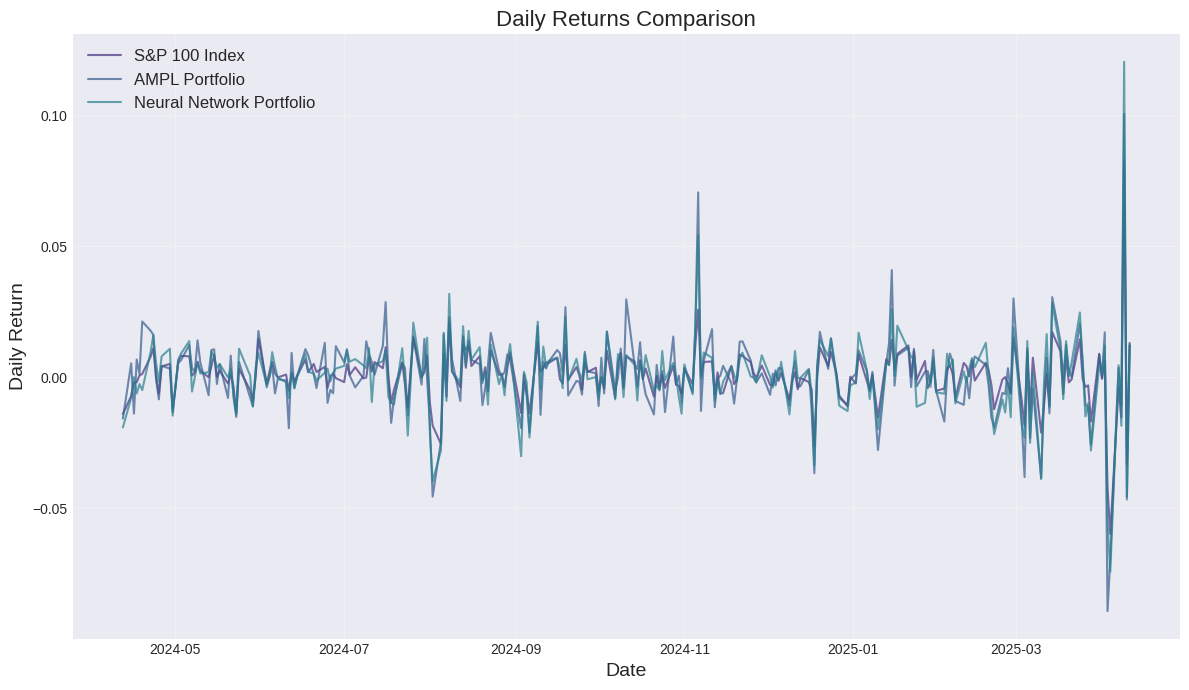


SUMMARY OF RESULTS ACROSS DIFFERENT TIME HORIZONS

Tracking Error (lower is better):
Time Horizon    AMPL            Neural Network  Winner    
-------------------------------------------------------
3mo             0.1634          0.1437          NN        
6mo             0.1488          0.1172          NN        
9mo             0.1379          0.1090          NN        
1y              0.1294          0.0994          NN        

Correlation with Index (higher is better):
Time Horizon    AMPL            Neural Network  Winner    
-------------------------------------------------------
3mo             0.9403          0.9628          NN        
6mo             0.9210          0.9566          NN        
9mo             0.9088          0.9546          NN        
1y              0.8967          0.9476          NN        

Annualized Return (higher is better):
Time Horizon    AMPL            Neural Network  Winner    
-------------------------------------------------------
3mo           

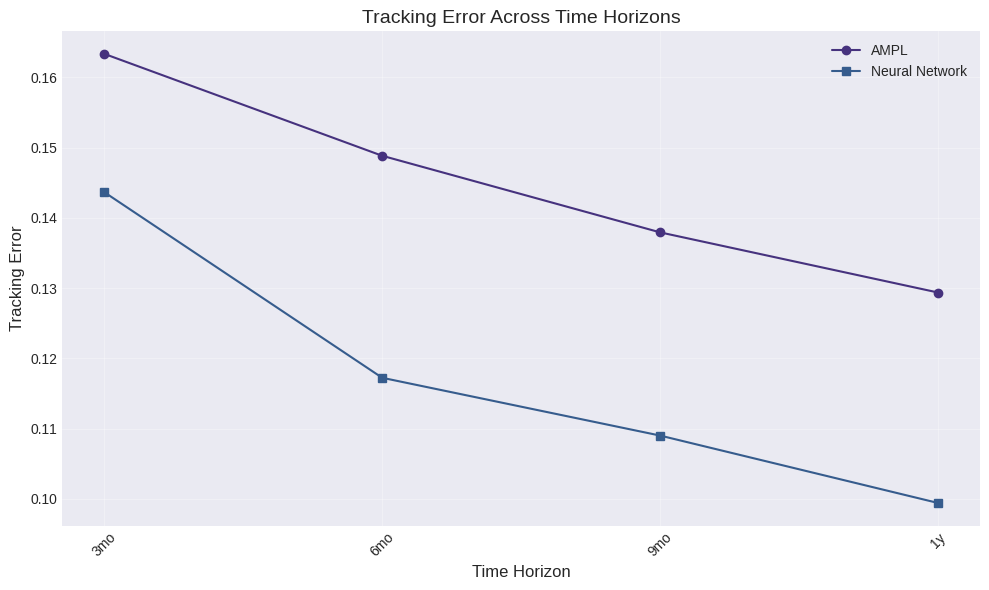

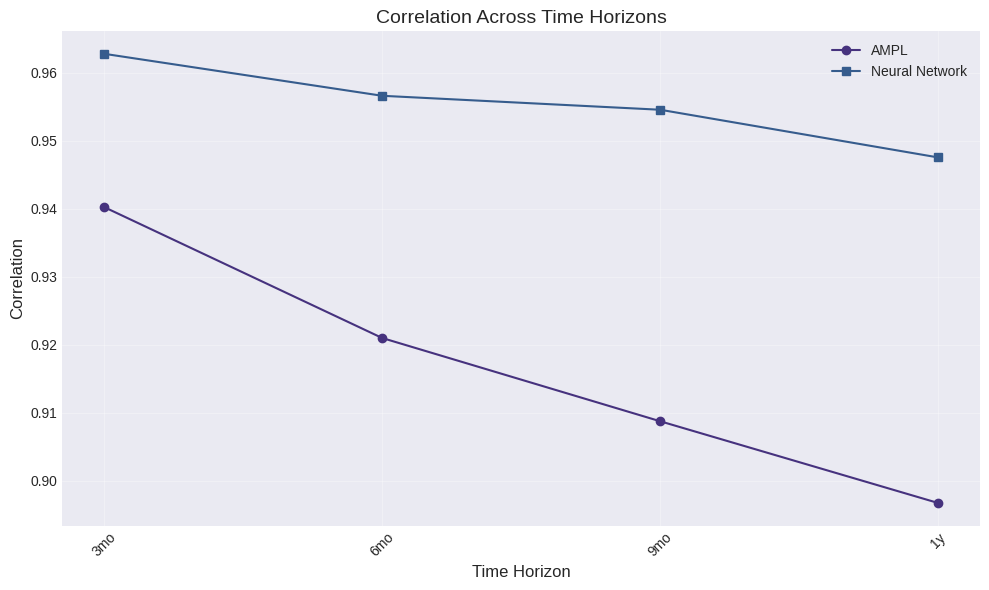


Time Horizon Analysis Conclusions:

1. Stability of tracking performance:
   - AMPL: Tracking error standard deviation = 0.0127
   - Neural Network: Tracking error standard deviation = 0.0165
   - AMPL approach shows more stable tracking performance across time horizons

2. Best performing time horizon:
   - AMPL: Best performance in 1y period (TE=0.1294)
   - Neural Network: Best performance in 1y period (TE=0.0994)

3. Overall consistency:
   - AMPL outperforms in 0/4 time horizons
   - Neural Network outperforms in 4/4 time horizons
   - Neural Network approach is more consistently effective across different time horizons

4. Additional insights:

5. Practical recommendations:
   - For short-term tracking (3-6 months): Neural Network approach is preferable
   - For long-term tracking (9-12 months): Neural Network approach is preferable

COMPREHENSIVE ANALYSIS SUMMARY AND INSIGHTS

1. Comparison of AI-Driven Approaches:

   A. AMPL Optimization Approach:
      - Uses mixed-integer l

In [5]:

if __name__ == "__main__":
    # Initialize AMPL
    try:
        ampl = ampl_notebook(
            modules=["highs", "cbc", "gurobi", "cplex"],
            license_uuid="ef216baf-1a82-48a2-ad66-5e4609a7f099"
        )
        print("AMPL initialized successfully")
    except Exception as e:
        print(f"Warning: AMPL initialization failed: {e}")
        print("Will try to initialize inside the class.")
        ampl = None

    # Create index fund tracker with diversification constraint (max_weight=0.20)
    fund = SPIndexFund(q=15, lookback_period='2y', test_period='6mo', ampl=ampl, max_weight=0.20)

    # Run comprehensive analysis with parameter exploration and time horizon analysis
    results = fund.run_full_analysis()